In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=be2c45804c855edf315e4b55c7316010916732992e2609e5b5bd75081db4d78f
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
np.NaN = np.nan
import pandas_ta as ta
import tensorflow as tf
import random
import requests
import matplotlib.pyplot as plt


from keras.layers import Dense, Input, Activation, LSTM
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import LSTM, Dense

from keras import optimizers

In [ ]:
k = 33
np.random.seed(k)
tf.random.set_seed(k)
random.seed(k)
q = 3
ts = 3

In [ ]:
data_ori = pd.read_csv('/content/drive/MyDrive/NIFTY_2007_21-03-25')
xdata = data_ori.tail(18755)#80755
#xdata = data_ori
xdata.shape



'''url = "https://priceapi.moneycontrol.com/techCharts/indianMarket/index/history?symbol=in%3BNSX&resolution=5&from=1743212675&to=1743115675&countback=20000&currencyCode=INR"
header = {

    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=header)

data_ori = pd.DataFrame(res.json())

data_ori.rename(columns={'c': 'close', 'h': 'high', 'l' : 'low', 'o' : 'open'}, inplace=True)

#xdata = data_ori
xdata = data_ori.iloc[:-110, :]
'''


'url = "https://priceapi.moneycontrol.com/techCharts/indianMarket/index/history?symbol=in%3BNSX&resolution=5&from=1743212675&to=1743115675&countback=20000&currencyCode=INR"\nheader = {\n\n    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"\n}\n\nres = requests.get(url, headers=header)\n\ndata_ori = pd.DataFrame(res.json())\n\ndata_ori.rename(columns={\'c\': \'close\', \'h\': \'high\', \'l\' : \'low\', \'o\' : \'open\'}, inplace=True)\n\n#xdata = data_ori\nxdata = data_ori.iloc[:-110, :]\n'

In [ ]:
def create_sequences(X, y, ts):
    """
    Create sequences for LSTM model from the dataset
    X: features array of shape (n_samples, n_features)
    y: target array of shape (n_samples, 1)
    ts: number of historical candles to use
    """
    # Validate input types
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        X = np.array(X)
        y = np.array(y)

    # Validate shapes
    if len(X.shape) != 2 or len(y.shape) != 2:
        raise ValueError(f"Expected 2D arrays, got X shape {X.shape} and y shape {y.shape}")

    if X.shape[0] != y.shape[0]:
        raise ValueError(f"X and y must have same number of samples. Got {X.shape[0]} and {y.shape[0]}")

    if ts >= X.shape[0]:
        raise ValueError(f"ts ({ts}) must be less than number of samples ({X.shape[0]})")

    X_seq = []
    y_seq = []

    for i in range(len(X) - ts):
        X_seq.append(X[i:(i + ts)])
        y_seq.append(y[i + ts])

    return np.array(X_seq), np.array(y_seq)

In [ ]:
i = 1

trima_temp = pd.DataFrame()
xdata_pre = pd.DataFrame()
slaes = 33

fi_data = xdata[['close']]
c = fi_data

############################## Indicators  ############################################################33


c['returns'] = c.close.pct_change()

returns = np.log(c['close'] / c['close'].shift(1))  # Log returns
c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


trima_temp['TRIMA10'] = ta.mom(c['close'], length=8).iloc[slaes:]



data = c.iloc[slaes:]
data = data.reset_index(drop=True)

target = pd.DataFrame()
target = target.reset_index(drop=True)


target['1TRIMA10'] = trima_temp['TRIMA10'].shift(-i)

target_fi = target.iloc[:-i, :]
data_fi = data.iloc[:-i, :]

print('data',data_fi.head(3))



from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scx = MinMaxScaler(feature_range=(0,1))

x_train = sc.fit_transform(data_fi)
y_train = scx.fit_transform(target_fi)


X_seq, y_seq = create_sequences(x_train, y_train, ts)

print('xxxx', X_seq, 'yyyy',y_seq)

# Create the LSTM model
lstm_in = Input(shape=(ts,q), name='lstm_in')
inputs = LSTM(408, name ='first_layer')(lstm_in)#3000
inputs = Dense(1, name = 'dense_layer')(inputs)
output = Activation('linear', name= 'output')(inputs)
model = Model(inputs = lstm_in, outputs = output)
adam = optimizers.Adam(learning_rate=0.00001)#0.00001
model.compile(optimizer = adam, loss= 'mse')


# Print model summary
model.summary()

# Train the model
history = model.fit(
    x=X_seq,
    y=y_seq,
    batch_size=20,
    epochs=5,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


data       close   returns  inute_volatility
0  21948.25  0.001001          0.284102
1  21948.15 -0.000005          0.284248
2  21965.70  0.000800          0.288656
xxxx [[[0.12534757 0.50131665 0.13255137]
  [0.12532735 0.48002099 0.1326298 ]
  [0.12887635 0.49705028 0.13499116]]

 [[0.12532735 0.48002099 0.1326298 ]
  [0.12887635 0.49705028 0.13499116]
  [0.12667213 0.46960921 0.13483654]]

 [[0.12887635 0.49705028 0.13499116]
  [0.12667213 0.46960921 0.13483654]
  [0.12396235 0.46719264 0.13498014]]

 ...

 [[0.4063963  0.48683416 0.09829849]
  [0.40982397 0.49549742 0.10038071]
  [0.40814552 0.47259176 0.1000209 ]]

 [[0.40982397 0.49549742 0.10038071]
  [0.40814552 0.47259176 0.1000209 ]
  [0.4079433  0.47921044 0.09946886]]

 [[0.40814552 0.47259176 0.1000209 ]
  [0.4079433  0.47921044 0.09946886]
  [0.41062274 0.49213621 0.09763985]]] yyyy [[0.5424033 ]
 [0.51488768]
 [0.51644955]
 ...
 [0.56579822]
 [0.5701183 ]
 [0.56297355]]


<ipython-input-16-243d118cb292>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-16-243d118cb292>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_in (InputLayer)            │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (LSTM)              │ (None, 408)            │       672,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 1)              │           409 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Activation)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,793 (2.57 MB)

 Trainable params: 672,793 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2081 - val_loss: 0.0207
Epoch 2/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 3/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 4/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0018 - val_loss: 9.5971e-04


In [ ]:
url = "https://priceapi.moneycontrol.com/techCharts/indianMarket/index/history?symbol=in%3BNSX&resolution=5&from=1743212675&to=1743115675&countback=20000&currencyCode=INR"
header = {
             #1744945425
             #1743115675

    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=header)

data_ori = pd.DataFrame(res.json())

data_ori.rename(columns={'c': 'close', 'h': 'high', 'l' : 'low', 'o' : 'open'}, inplace=True)

#xdata = data_ori
#xdata_pre = data_ori.iloc[:-170, :]


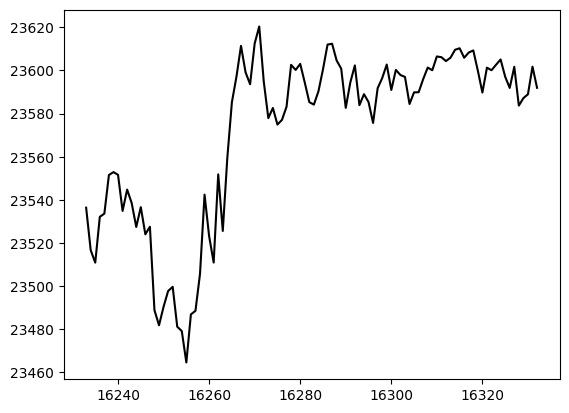

In [ ]:
plt.plot(data_ori['close'].tail(100), color = 'black', label = 'Prediction')

In [ ]:
def prepare_prediction_data(X, ts):
    """
    Create sequences for LSTM model from the dataset
    X: features array of shape (n_samples, n_features)
    y: target array of shape (n_samples, 1)
    ts: number of historical candles to use
    """
    # Validate input types
    if not isinstance(X, np.ndarray):
        X = np.array(X)


    # Validate shapes
    if len(X.shape) != 2:
        raise ValueError(f"Expected 2D arrays, got X shape {X.shape}")

    if ts >= X.shape[0]:
        raise ValueError(f"ts ({ts}) must be less than number of samples ({X.shape[0]})")

    X_seq = []

    for i in range(len(X) - ts):
        X_seq.append(X[i:(i + ts)])


    return np.array(X_seq)

In [ ]:
a = 10
b = 110

(16289, 3)
 24/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16288, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16287, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


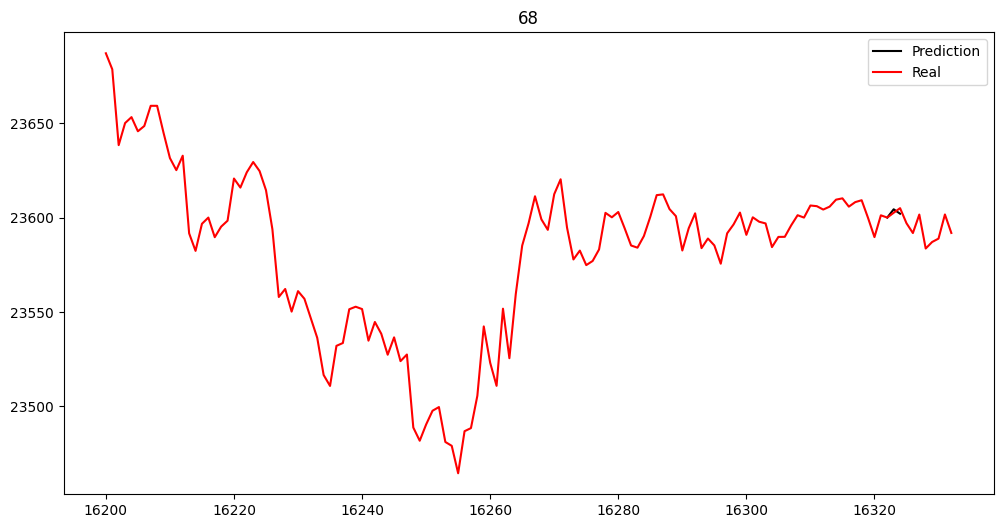

Actual: [23600.1, 23602.65, 23605.1]
prdiction [23600.1, 23604.489755249022, 23602.14946899414]
(16288, 3)
 70/509 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16287, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16286, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


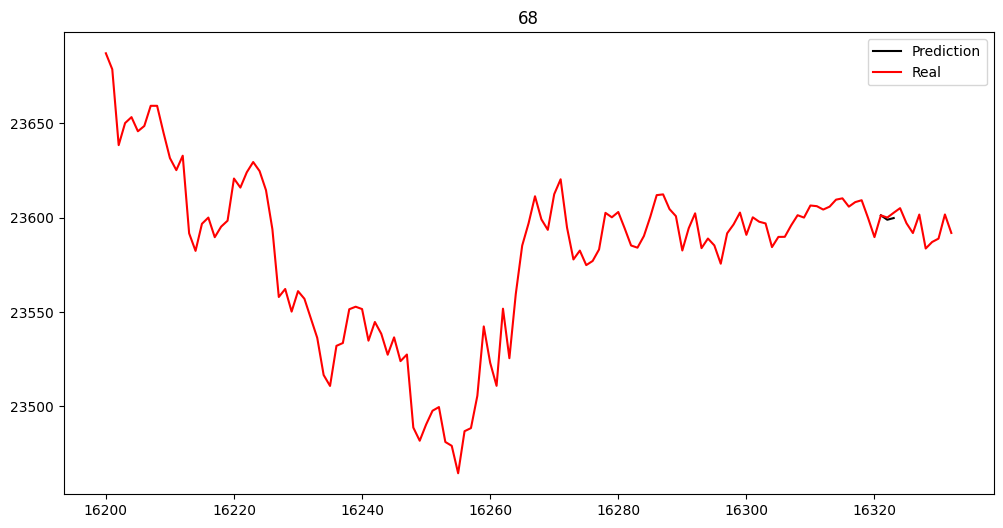

Actual: [23601.3, 23600.1, 23602.65]
prdiction [23601.3, 23598.959713745116, 23599.846661376952]
(16287, 3)
 68/509 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16286, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16285, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


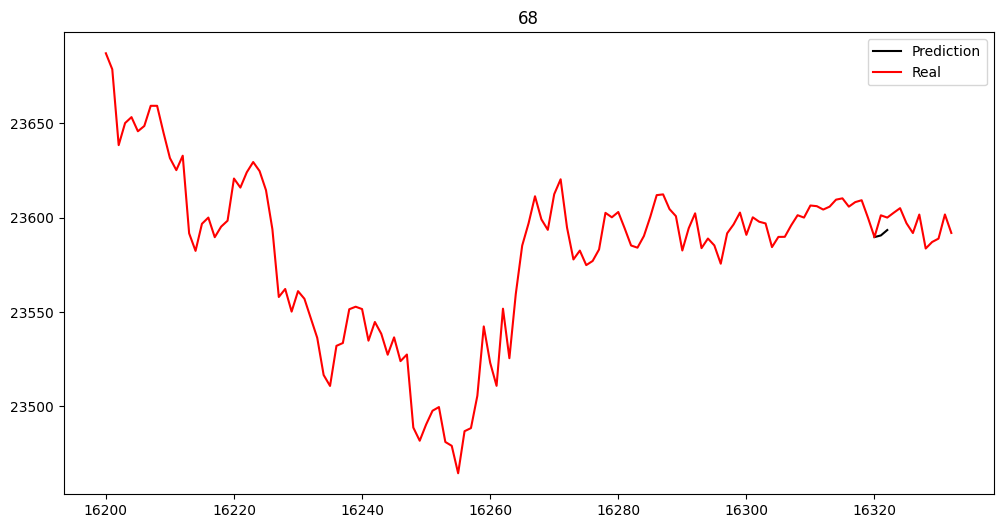

Actual: [23589.75, 23601.3, 23600.1]
prdiction [23589.75, 23590.636947631836, 23593.49843597412]
(16286, 3)
 66/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16285, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16284, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


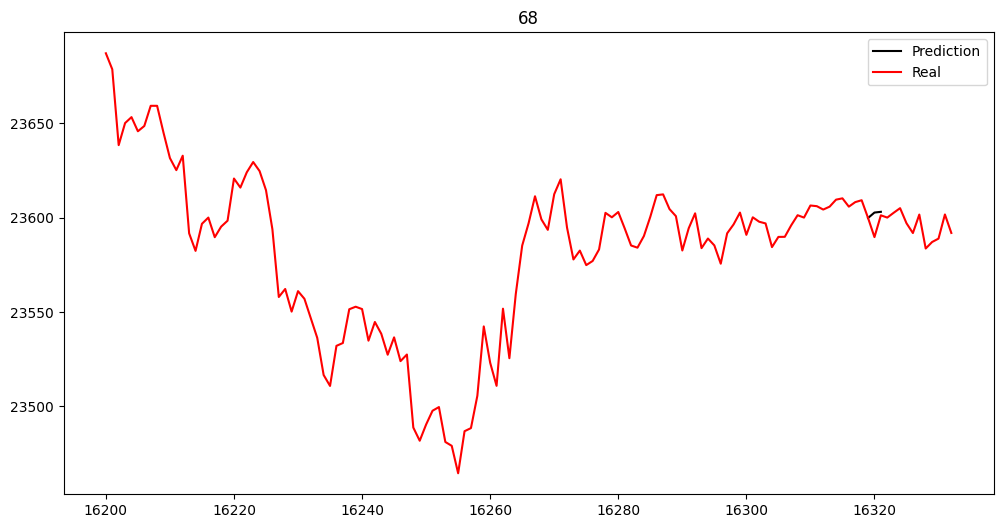

Actual: [23599.9, 23589.75, 23601.3]
prdiction [23599.9, 23602.761488342287, 23603.15562286377]
(16285, 3)
 56/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16284, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16283, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


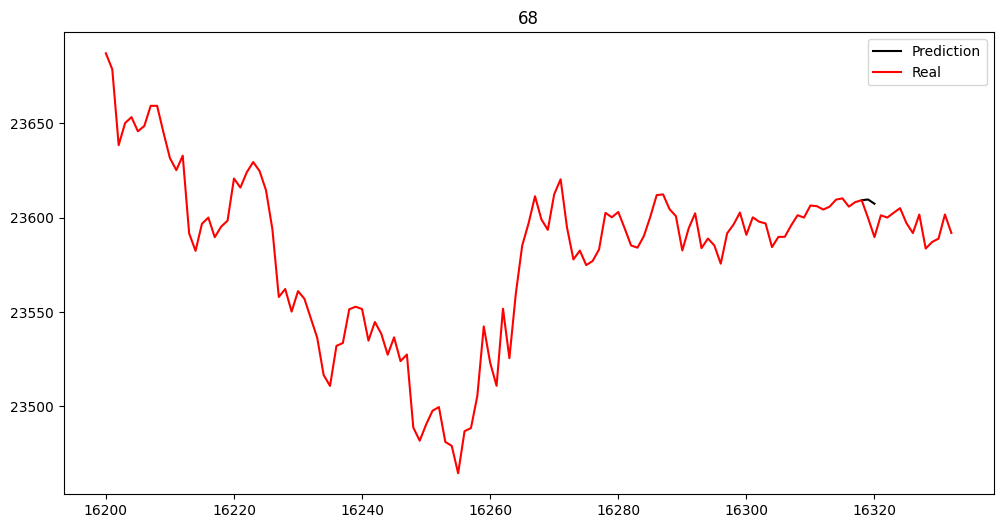

Actual: [23609.3, 23599.9, 23589.75]
prdiction [23609.3, 23609.694134521484, 23607.447956848144]
(16284, 3)
 68/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16283, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16282, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


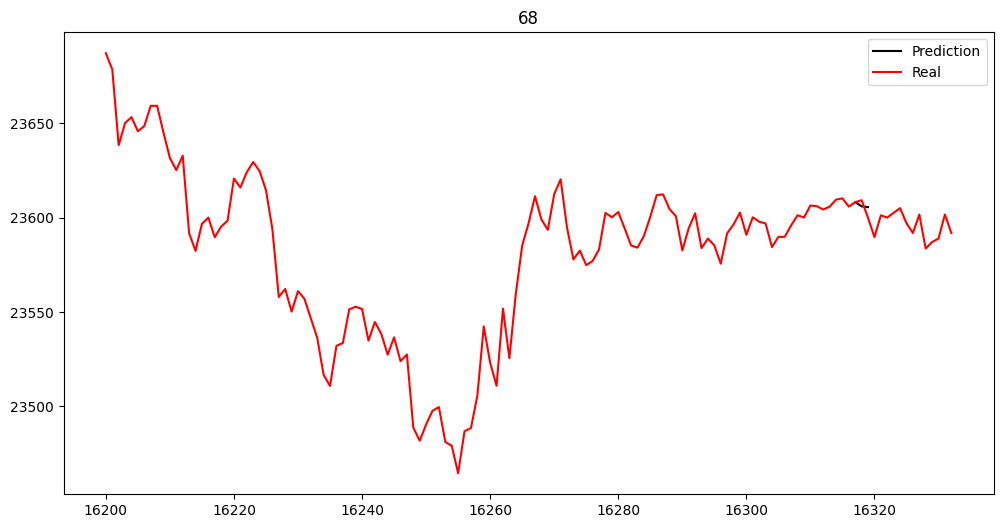

Actual: [23608.3, 23609.3, 23599.9]
prdiction [23608.3, 23606.05382232666, 23605.645573425292]
(16283, 3)
 65/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16282, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16281, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


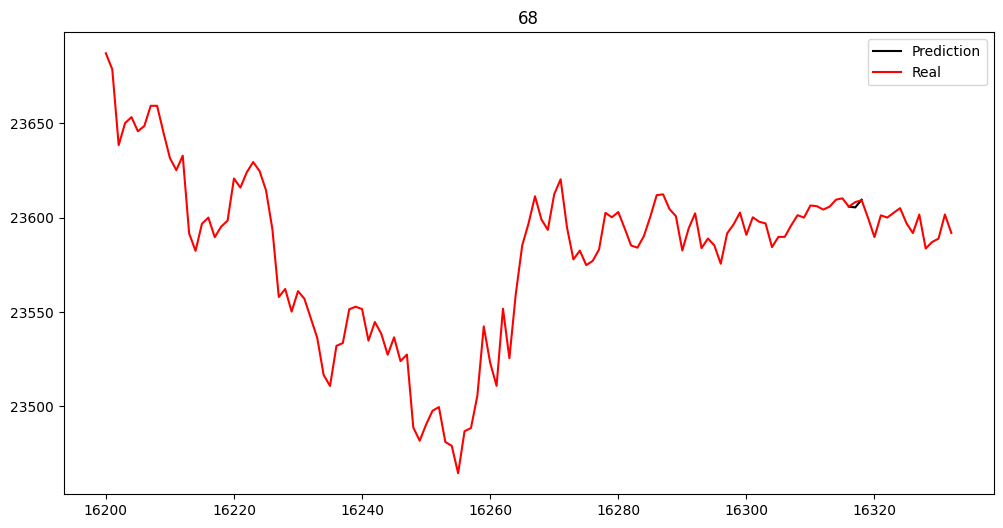

Actual: [23605.9, 23608.3, 23609.3]
prdiction [23605.9, 23605.491751098634, 23609.55195465088]
(16282, 3)
 65/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16281, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16280, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


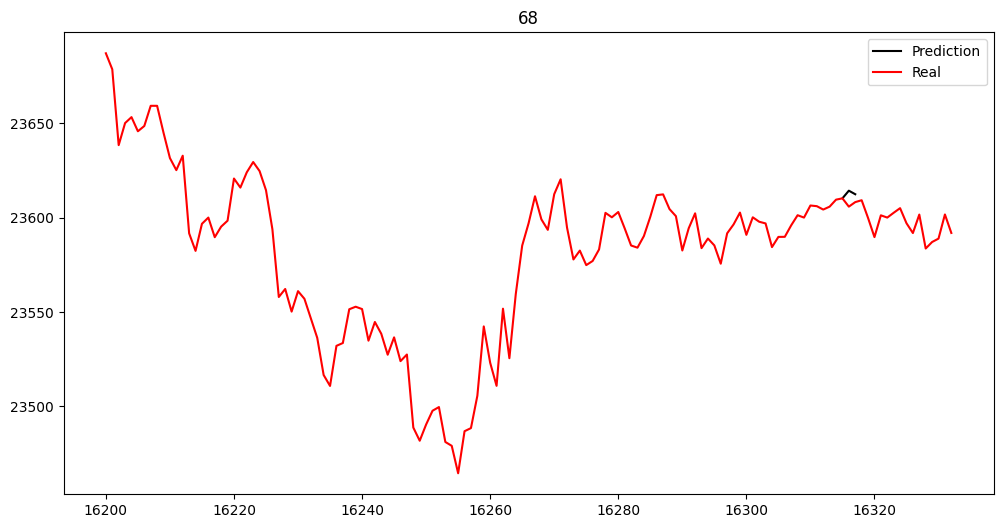

Actual: [23610.3, 23605.9, 23608.3]
prdiction [23610.3, 23614.360203552245, 23612.47738342285]
(16281, 3)
 63/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16280, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16279, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


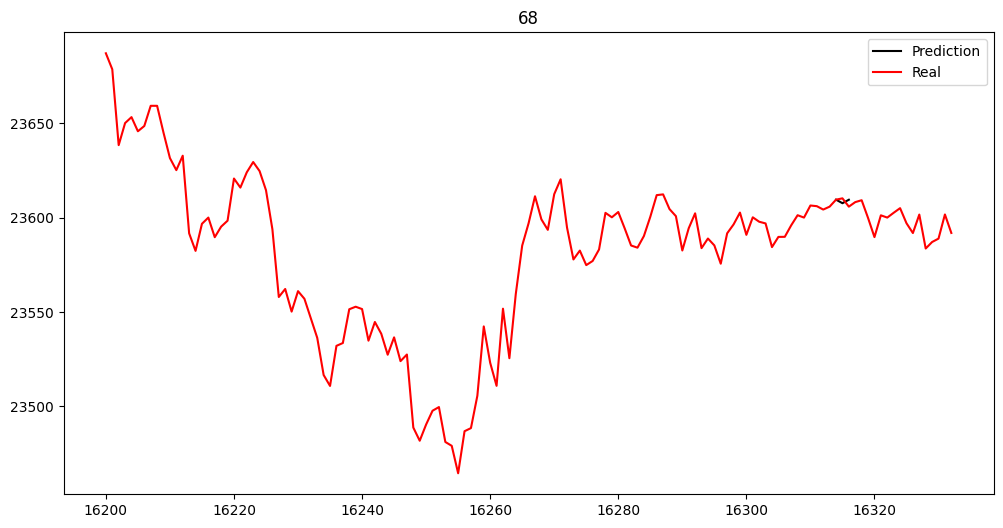

Actual: [23609.6, 23610.3, 23605.9]
prdiction [23609.6, 23607.717179870604, 23609.553865051268]
(16280, 3)
 21/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16279, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16278, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


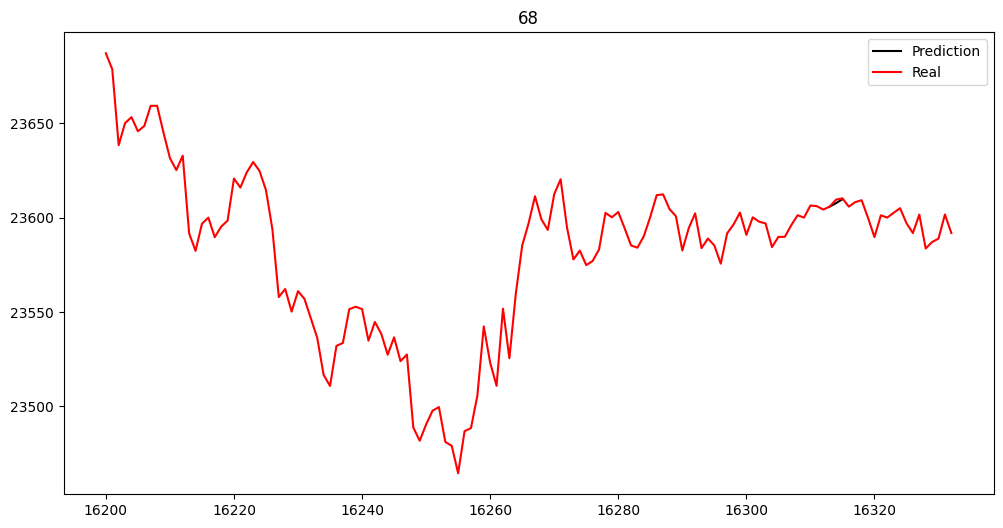

Actual: [23605.9, 23609.6, 23610.3]
prdiction [23605.9, 23607.736685180666, 23609.840803527833]
(16279, 3)
 62/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16278, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16277, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


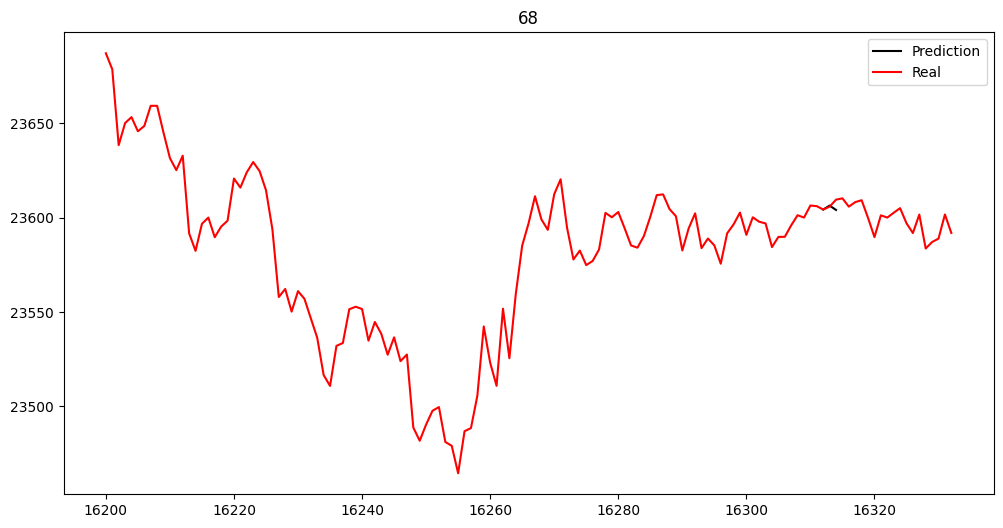

Actual: [23604.35, 23605.9, 23609.6]
prdiction [23604.35, 23606.454118347167, 23604.142320251463]
(16278, 3)
 66/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16277, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16276, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


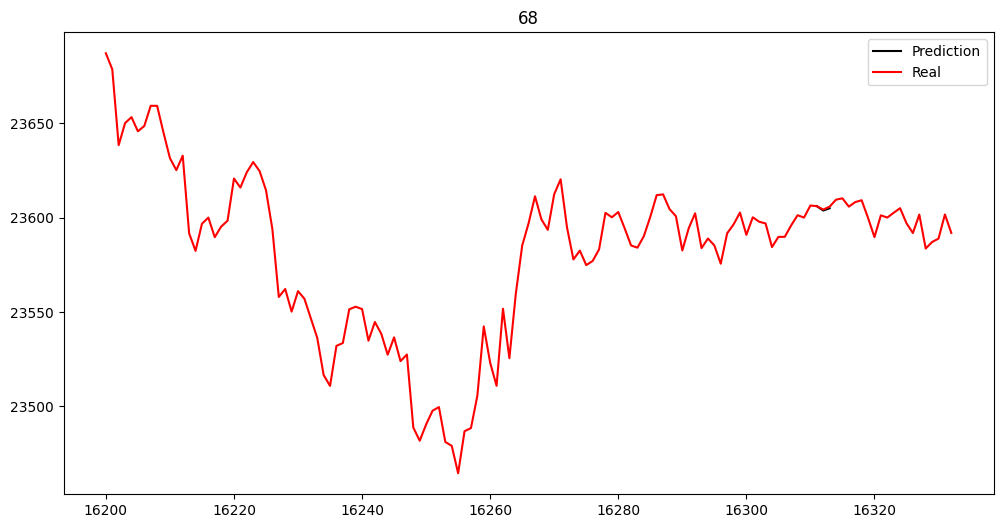

Actual: [23606.15, 23604.35, 23605.9]
prdiction [23606.15, 23603.8382019043, 23605.038793945314]
(16277, 3)
 35/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16276, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16275, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


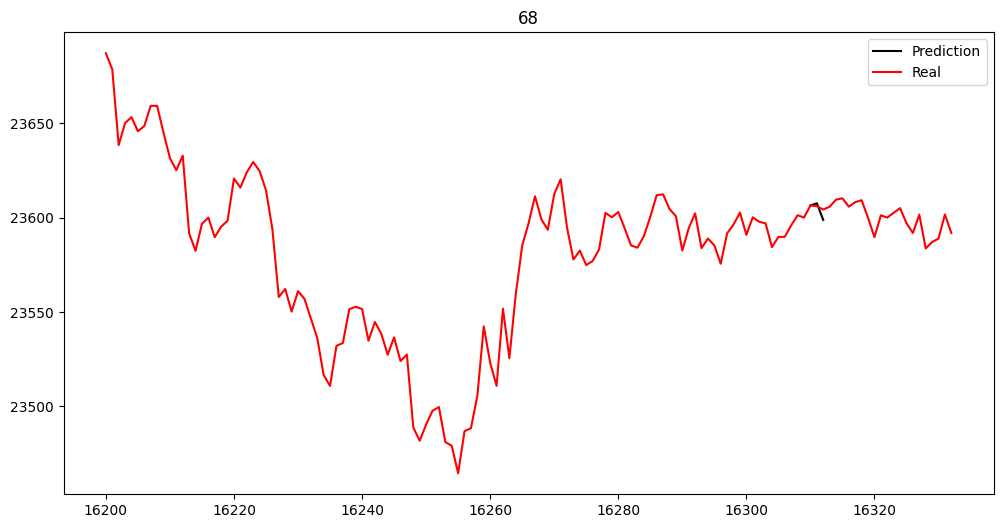

Actual: [23606.5, 23606.15, 23604.35]
prdiction [23606.5, 23607.700592041016, 23598.84381866455]
(16276, 3)
 59/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16275, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16274, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


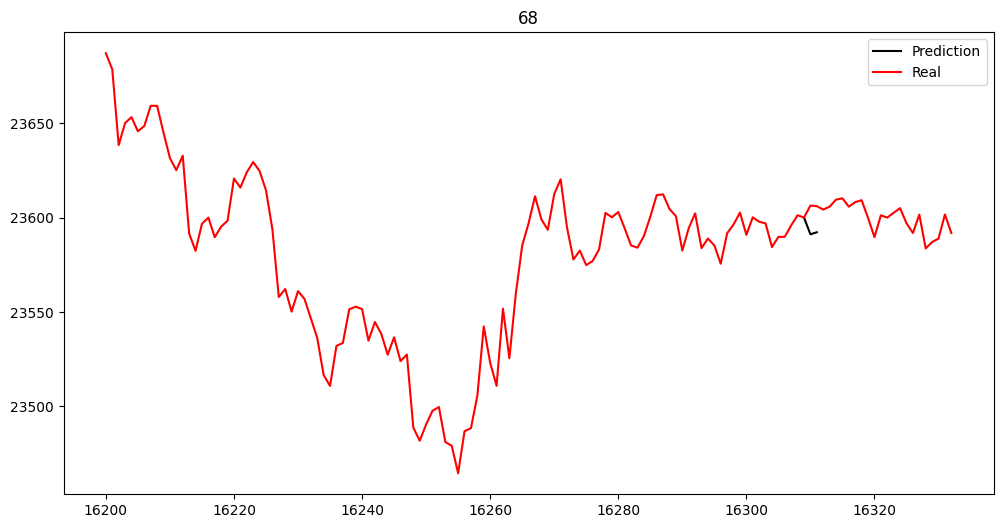

Actual: [23600.1, 23606.5, 23606.15]
prdiction [23600.1, 23591.243226623534, 23592.318589782713]
(16275, 3)
 56/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16274, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16273, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


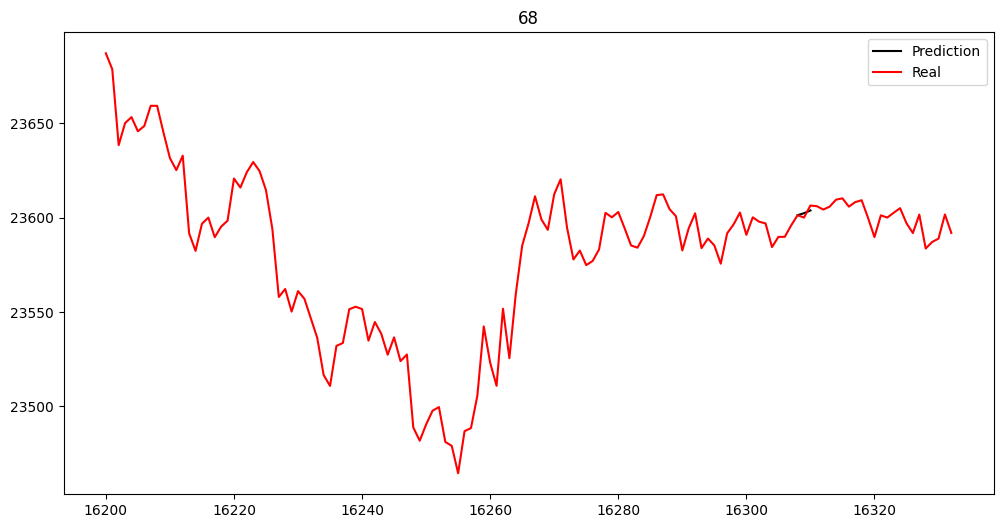

Actual: [23601.35, 23600.1, 23606.5]
prdiction [23601.35, 23602.42536315918, 23603.889321899413]
(16274, 3)
 65/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16273, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16272, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


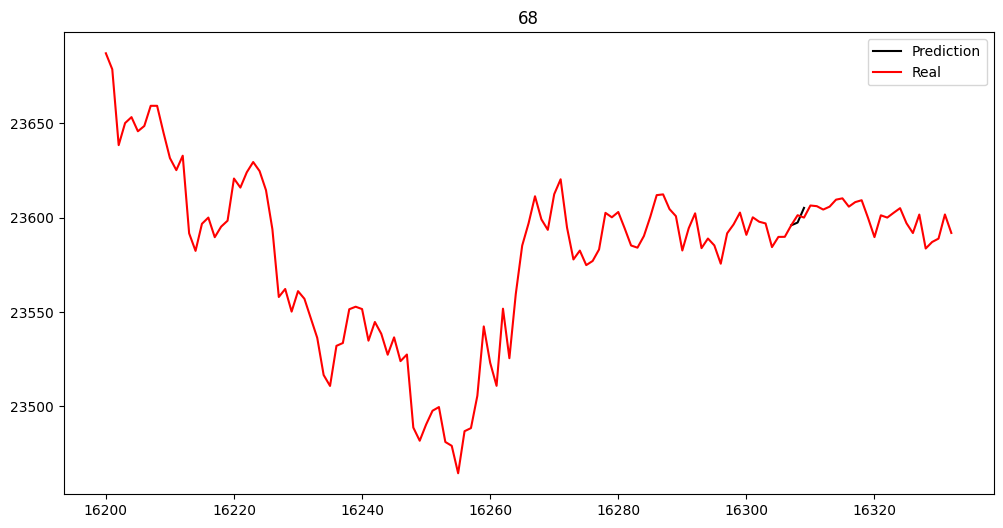

Actual: [23596.0, 23601.35, 23600.1]
prdiction [23596.0, 23597.463958740234, 23605.236946105957]
(16273, 3)
 66/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16272, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16271, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


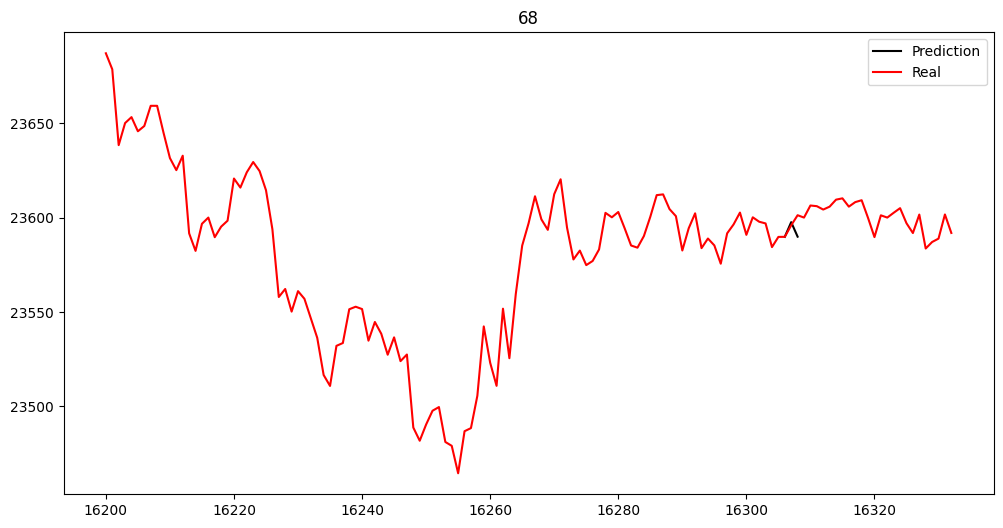

Actual: [23589.9, 23596.0, 23601.35]
prdiction [23589.9, 23597.672987365724, 23589.983267211916]
(16272, 3)
 65/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16271, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16270, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


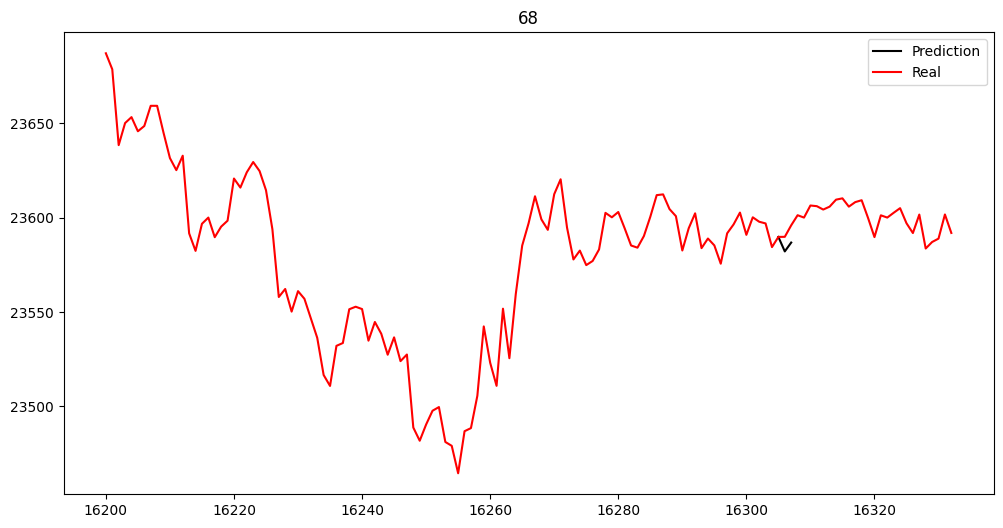

Actual: [23589.85, 23589.9, 23596.0]
prdiction [23589.85, 23582.16027984619, 23586.863687133788]
(16271, 3)
 63/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16270, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16269, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


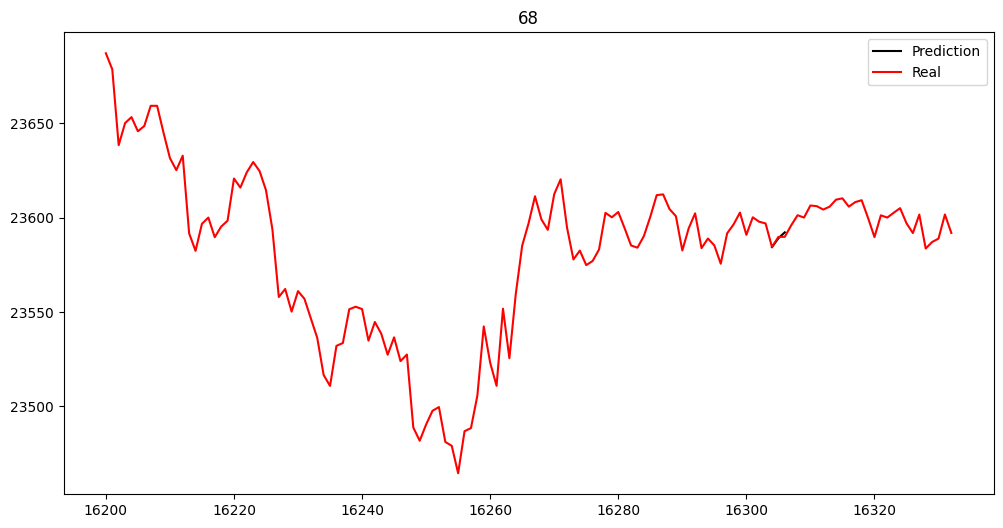

Actual: [23584.45, 23589.85, 23589.9]
prdiction [23584.45, 23589.1534072876, 23592.276904296876]
(16270, 3)
 63/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16269, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16268, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


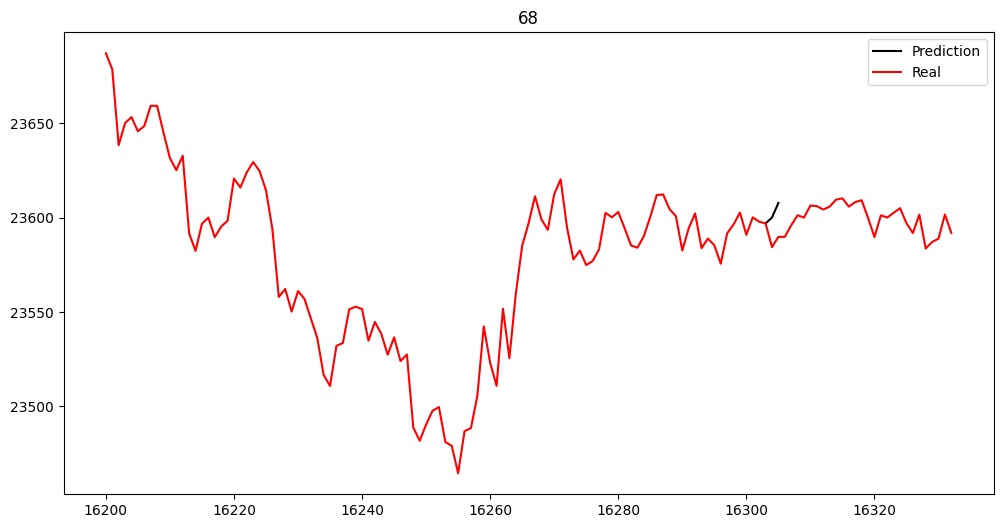

Actual: [23597.0, 23584.45, 23589.85]
prdiction [23597.0, 23600.123497009277, 23607.865447998047]
(16269, 3)
 60/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16268, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16267, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


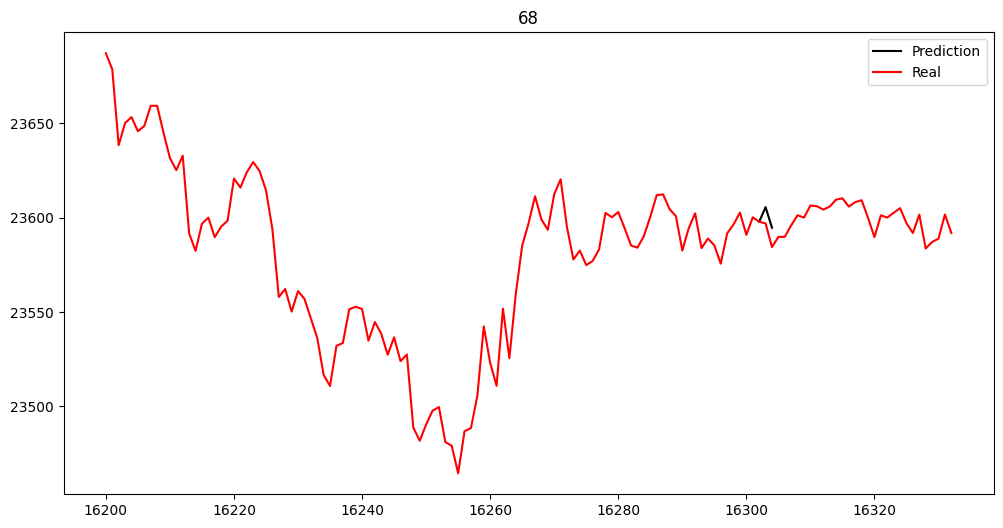

Actual: [23597.9, 23597.0, 23584.45]
prdiction [23597.9, 23605.64195098877, 23594.732473754884]
(16268, 3)
 63/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16267, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16266, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


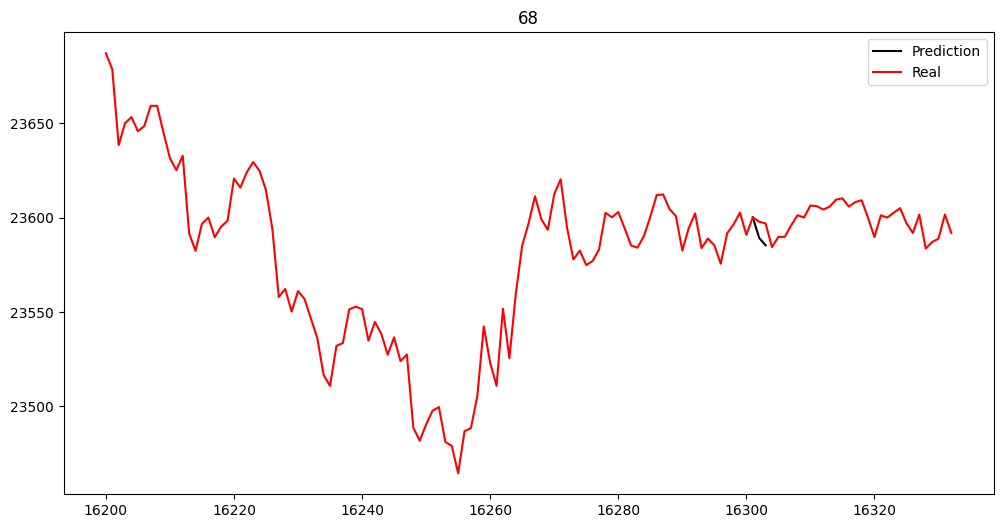

Actual: [23600.25, 23597.9, 23597.0]
prdiction [23600.25, 23589.340522766113, 23585.39528656006]
(16267, 3)
 60/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16266, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16265, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


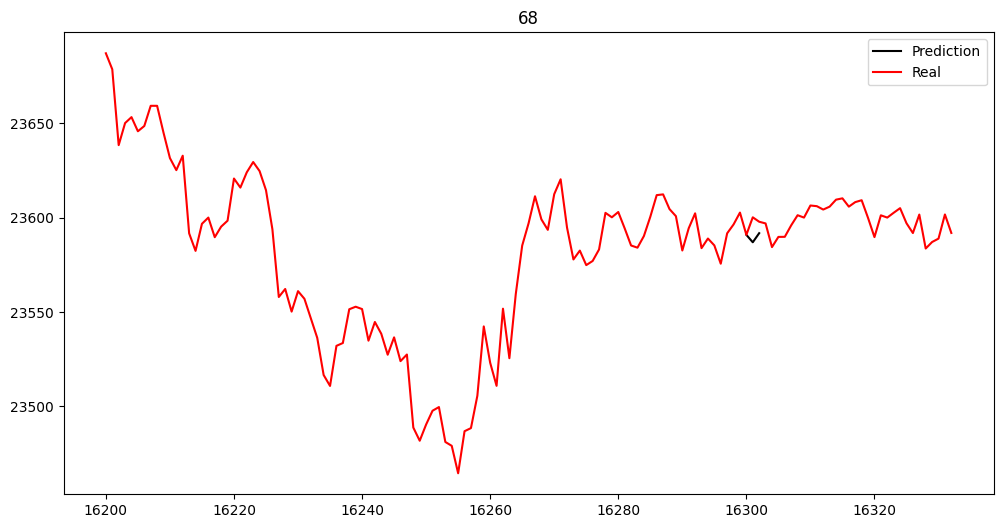

Actual: [23590.95, 23600.25, 23597.9]
prdiction [23590.95, 23587.004763793946, 23591.834078979493]
(16266, 3)
 57/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16265, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16264, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


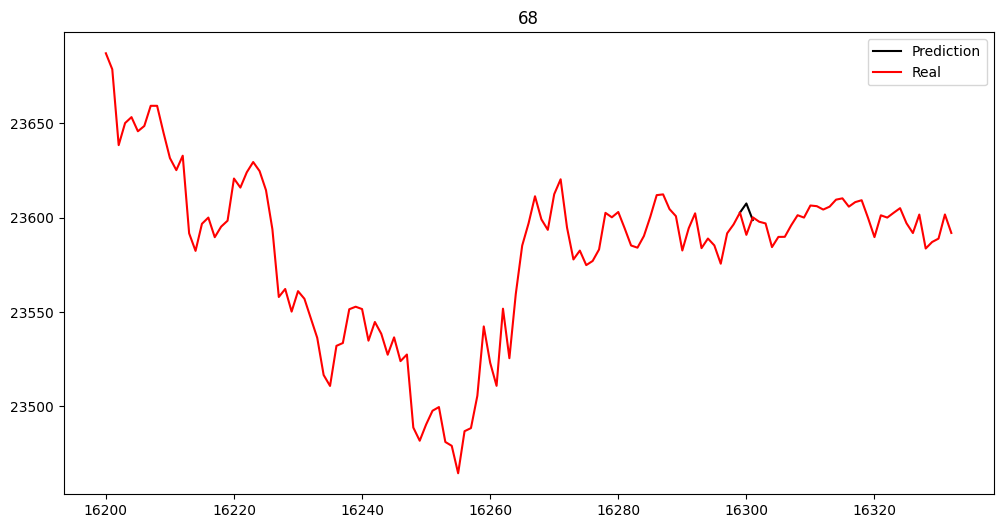

Actual: [23602.75, 23590.95, 23600.25]
prdiction [23602.75, 23607.579315185547, 23598.802001953125]
(16265, 3)
 63/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16264, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16263, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


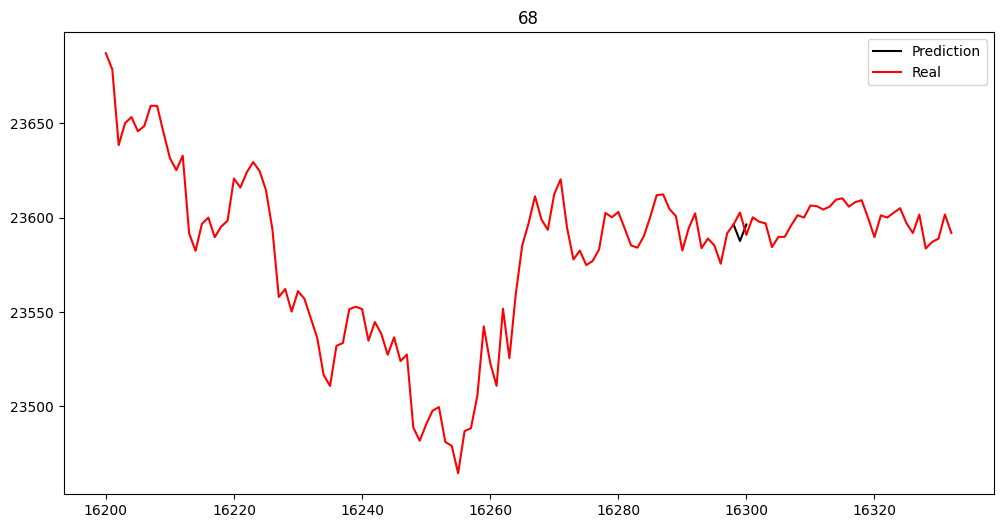

Actual: [23596.45, 23602.75, 23590.95]
prdiction [23596.45, 23587.67268676758, 23596.448390197755]
(16264, 3)
 21/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16263, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16262, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


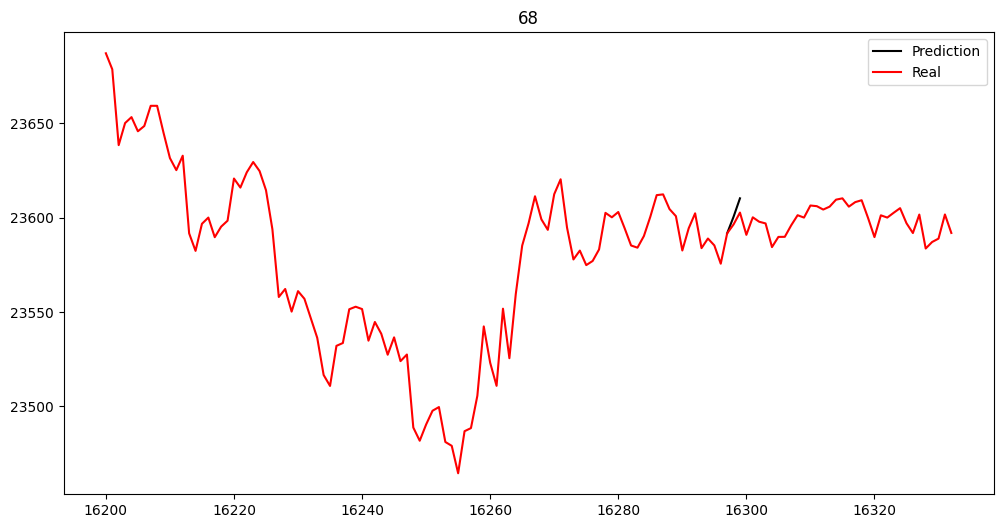

Actual: [23591.75, 23596.45, 23602.75]
prdiction [23591.75, 23600.525703430176, 23610.30297088623]
(16263, 3)
 62/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16262, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16261, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


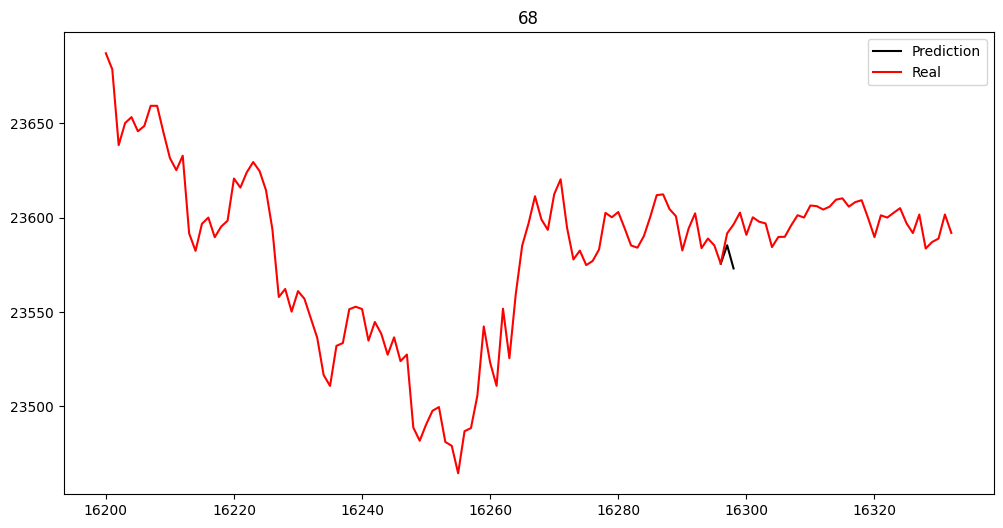

Actual: [23575.65, 23591.75, 23596.45]
prdiction [23575.65, 23585.427267456056, 23573.144583129884]
(16262, 3)
 58/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16261, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16260, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


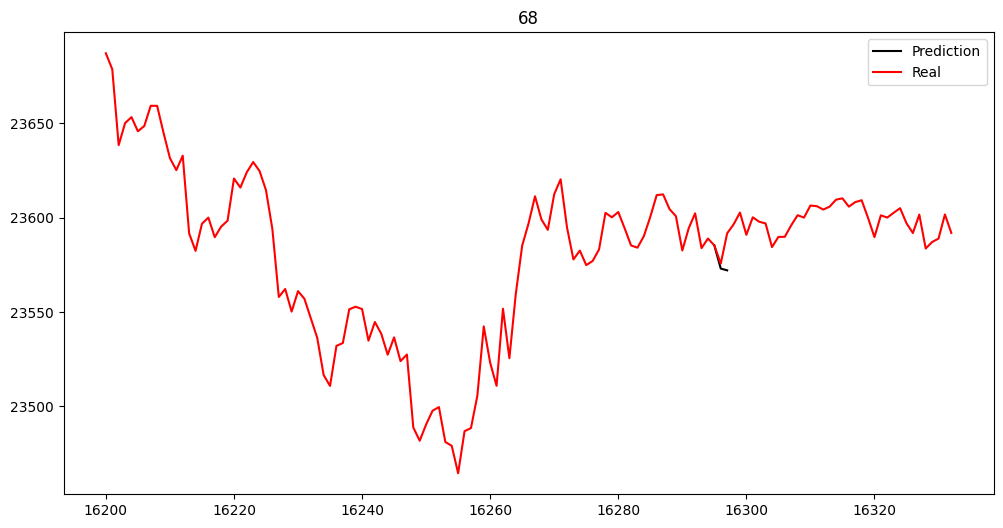

Actual: [23585.35, 23575.65, 23591.75]
prdiction [23585.35, 23573.067315673827, 23572.12742767334]
(16261, 3)
 25/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16260, 3)
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16259, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


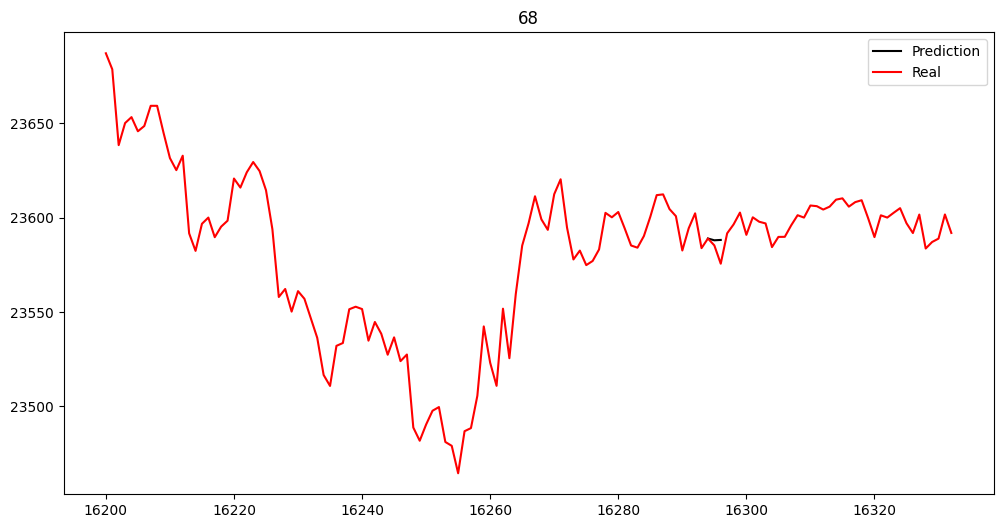

Actual: [23589.0, 23585.35, 23575.65]
prdiction [23589.0, 23588.06011199951, 23588.250282287598]
(16260, 3)
 59/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16259, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16258, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


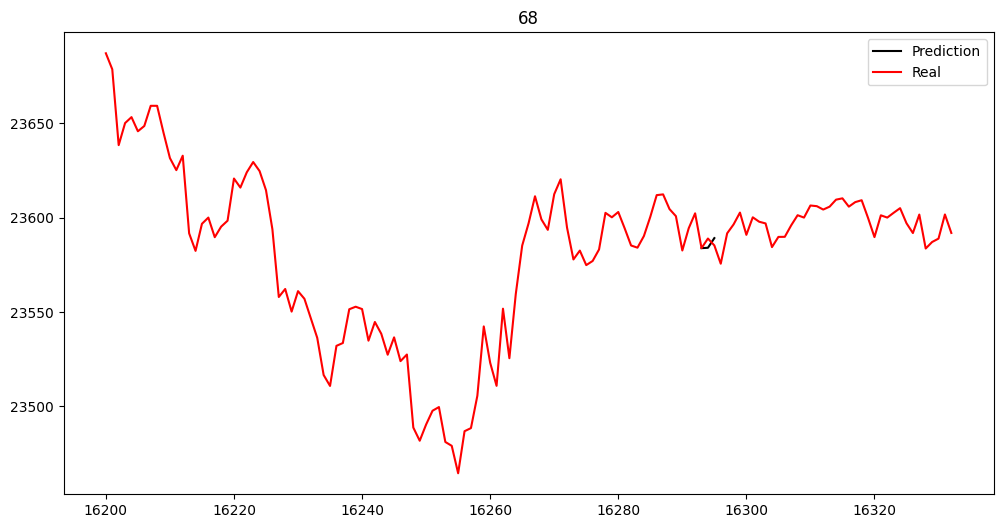

Actual: [23583.9, 23589.0, 23585.35]
prdiction [23583.9, 23584.090170288087, 23589.216612243654]
(16259, 3)
 61/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16258, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16257, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


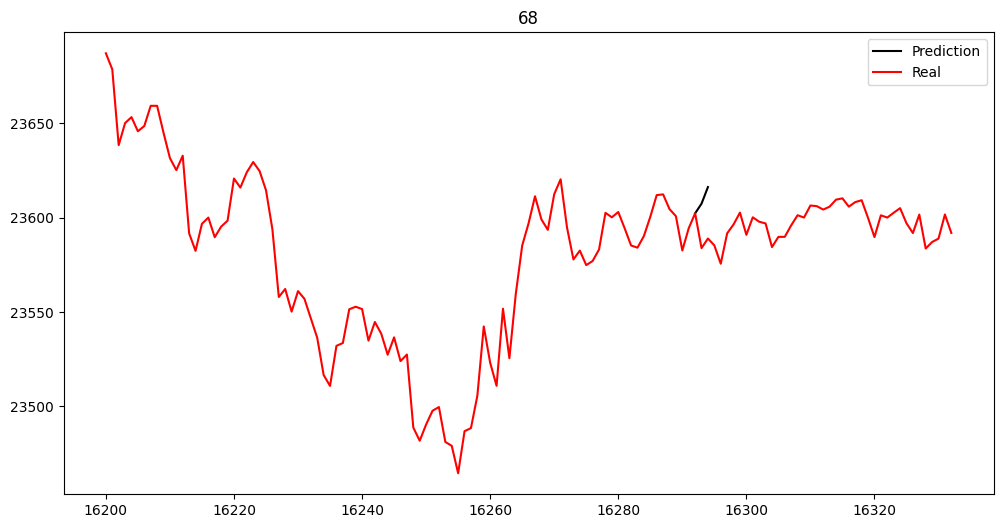

Actual: [23602.35, 23583.9, 23589.0]
prdiction [23602.35, 23607.476441955565, 23616.26957092285]
(16258, 3)
  1/508 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16257, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16256, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


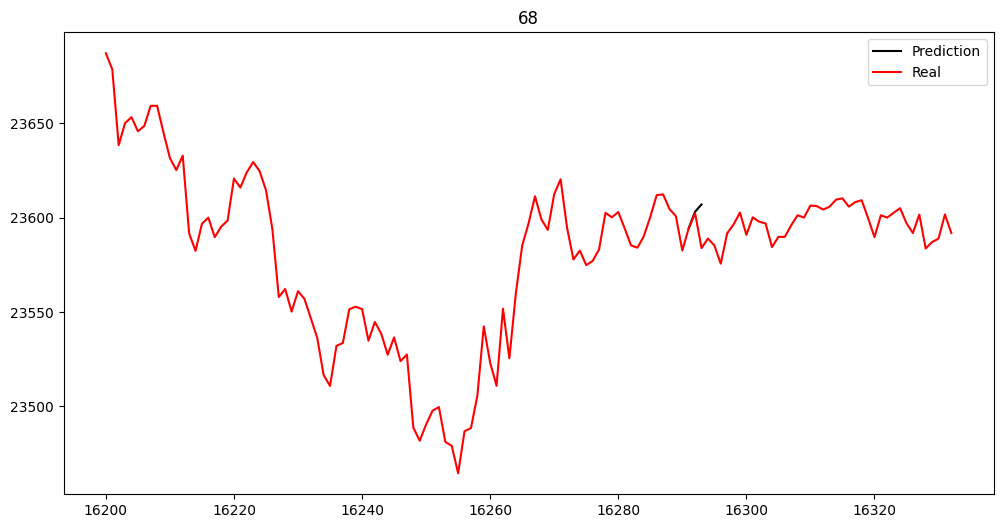

Actual: [23594.45, 23602.35, 23583.9]
prdiction [23594.45, 23603.243128967286, 23607.0543548584]
(16257, 3)
 59/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16256, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16255, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


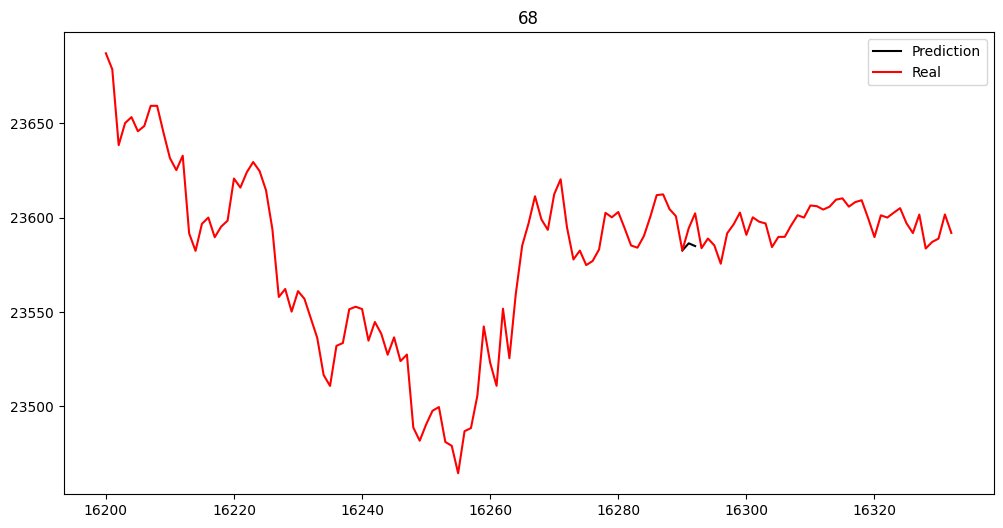

Actual: [23582.65, 23594.45, 23602.35]
prdiction [23582.65, 23586.461225891115, 23585.00802459717]
(16256, 3)
 61/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16255, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16254, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


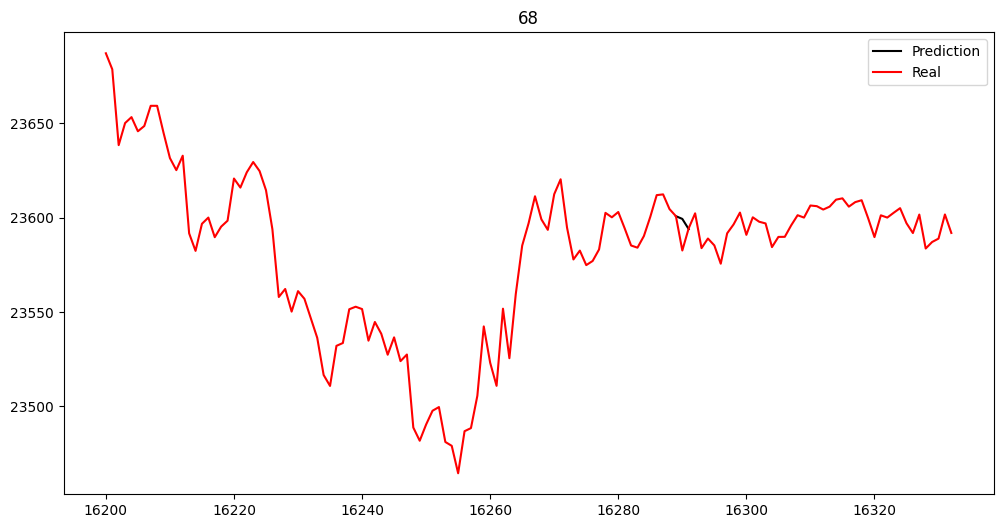

Actual: [23600.85, 23582.65, 23594.45]
prdiction [23600.85, 23599.396798706053, 23593.97162017822]
(16255, 3)
 61/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16254, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16253, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


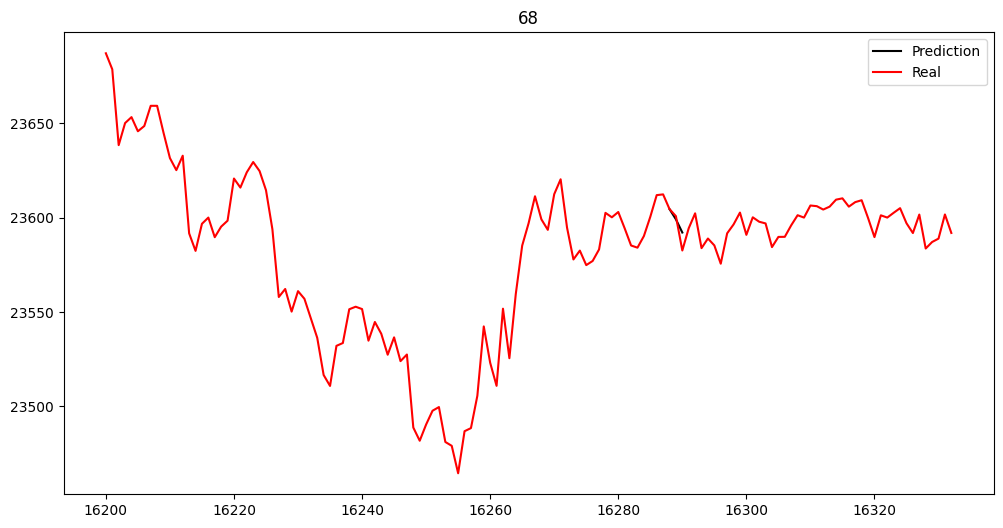

Actual: [23604.6, 23600.85, 23582.65]
prdiction [23604.6, 23599.174821472167, 23592.179048156737]
(16254, 3)
 53/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16253, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16252, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


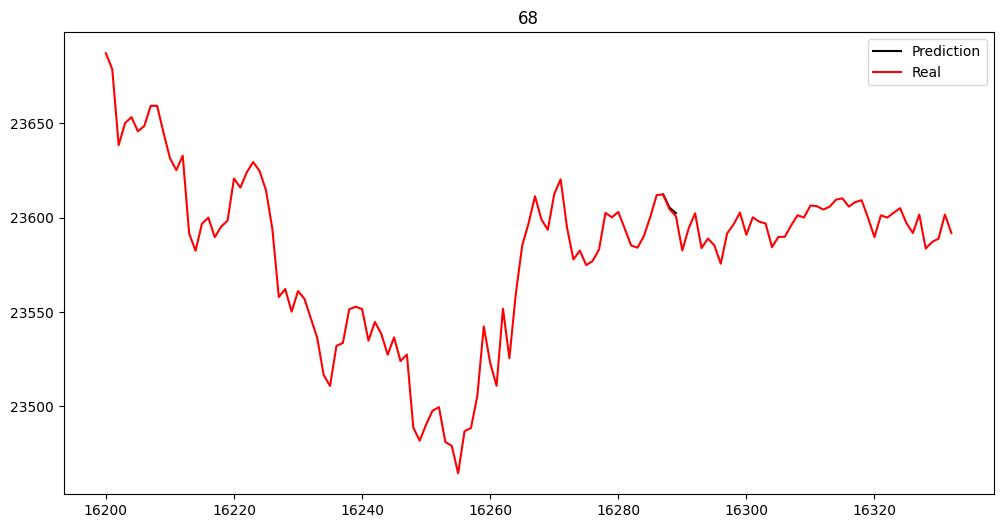

Actual: [23612.4, 23604.6, 23600.85]
prdiction [23612.4, 23605.40422668457, 23602.464628601076]
(16253, 3)
 58/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16252, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16251, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


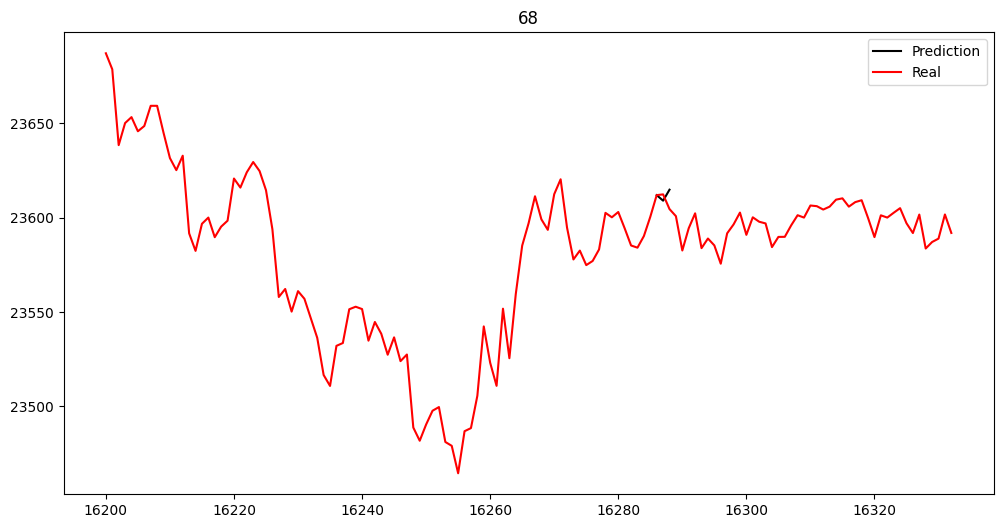

Actual: [23612.0, 23612.4, 23604.6]
prdiction [23612.0, 23609.060401916504, 23614.88330078125]
(16252, 3)
 58/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16251, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16250, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


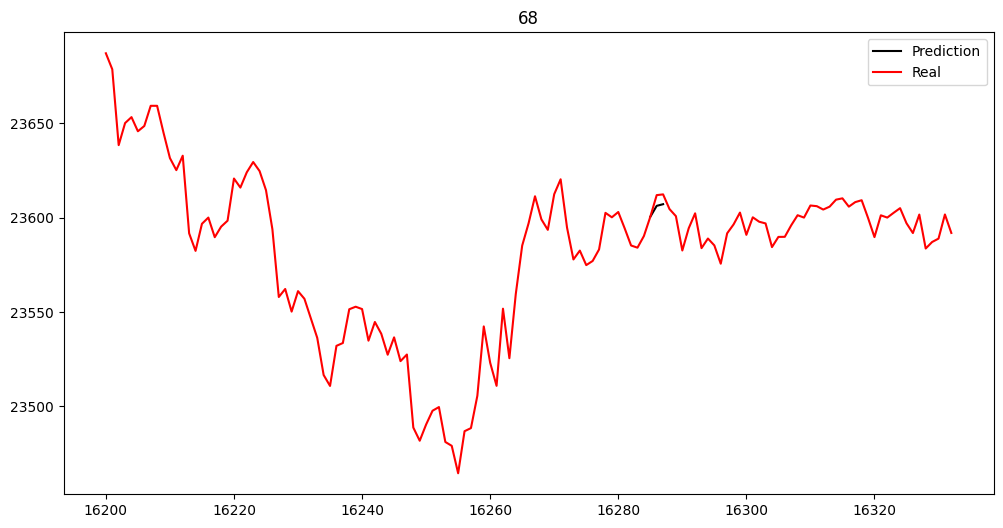

Actual: [23600.5, 23612.0, 23612.4]
prdiction [23600.5, 23606.322898864746, 23607.193717956543]
(16251, 3)
 55/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16250, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16249, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


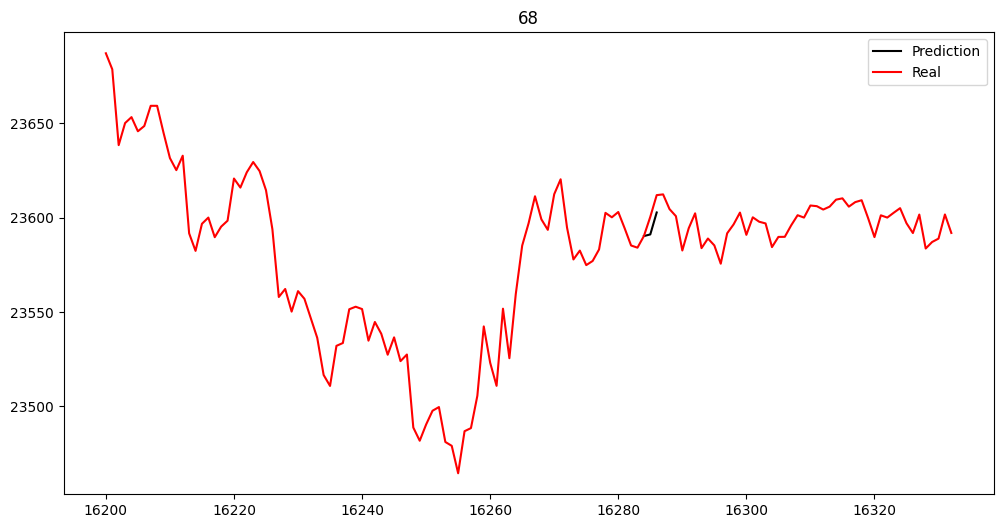

Actual: [23590.3, 23600.5, 23612.0]
prdiction [23590.3, 23591.170819091796, 23602.803898620605]
(16250, 3)
 45/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16249, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16248, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


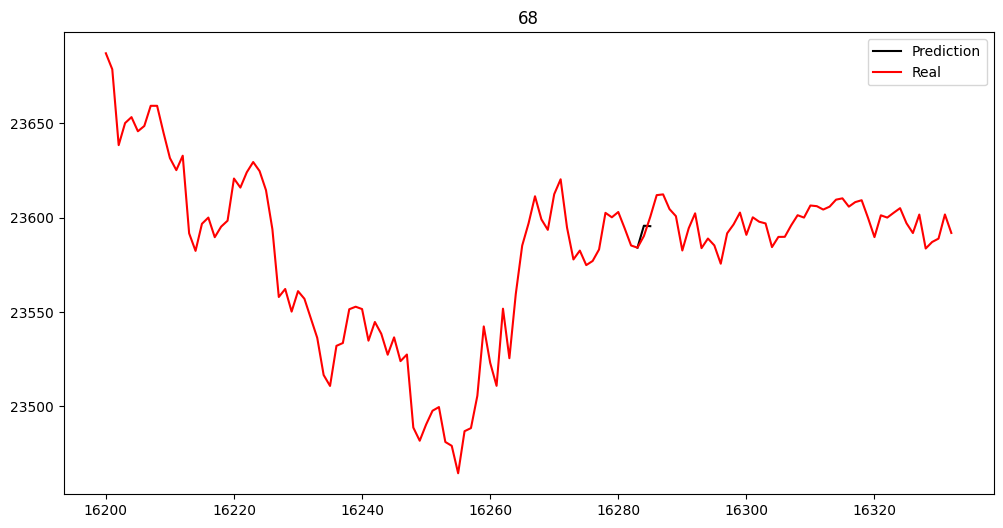

Actual: [23584.15, 23590.3, 23600.5]
prdiction [23584.15, 23595.78307952881, 23595.54408874512]
(16249, 3)
 58/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16248, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16247, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


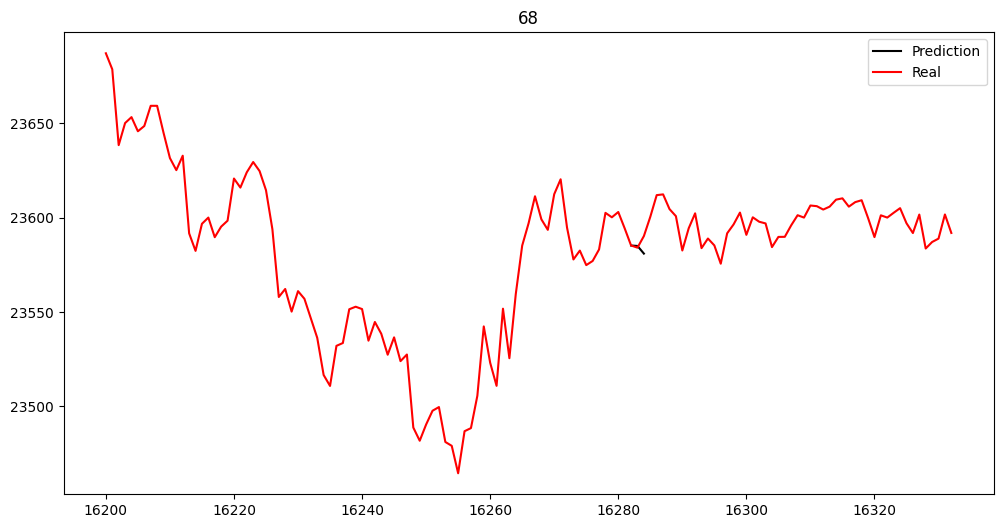

Actual: [23585.3, 23584.15, 23590.3]
prdiction [23585.3, 23585.061009216308, 23581.010075378417]
(16248, 3)
 61/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16247, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16246, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


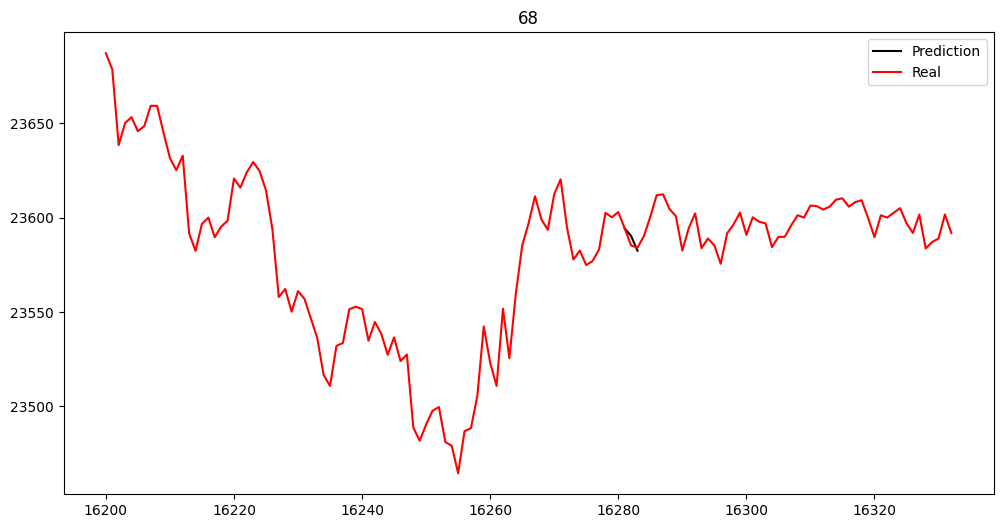

Actual: [23594.4, 23585.3, 23584.15]
prdiction [23594.4, 23590.34906616211, 23582.549520874025]
(16247, 3)
 26/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16246, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16245, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


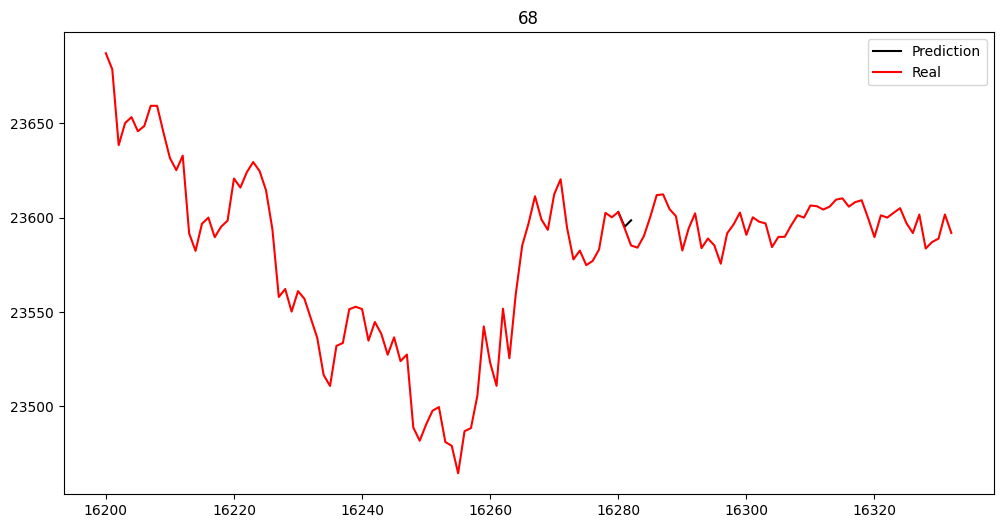

Actual: [23603.05, 23594.4, 23585.3]
prdiction [23603.05, 23595.250454711913, 23598.634175109863]
(16246, 3)
 45/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16245, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16244, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


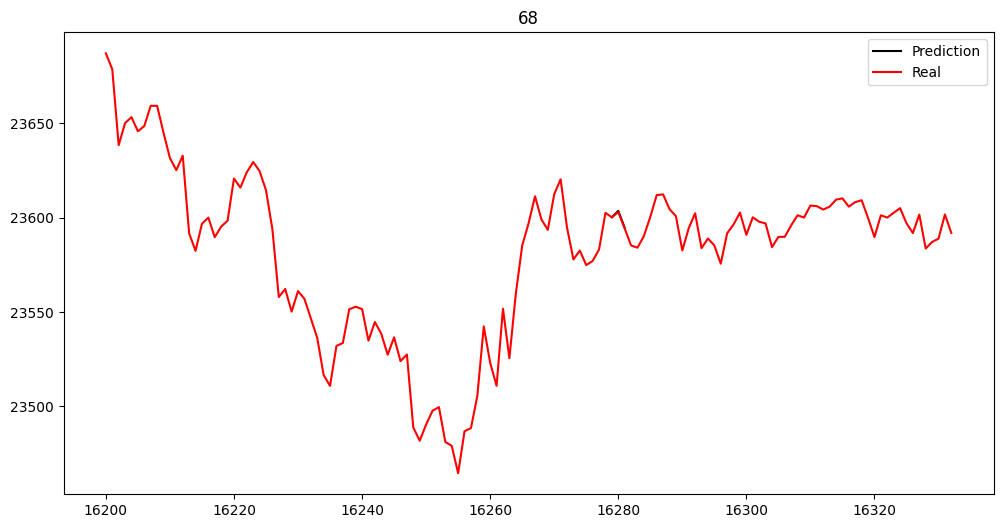

Actual: [23600.25, 23603.05, 23594.4]
prdiction [23600.25, 23603.63372039795, 23594.741241455078]
(16245, 3)
 57/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16244, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16243, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


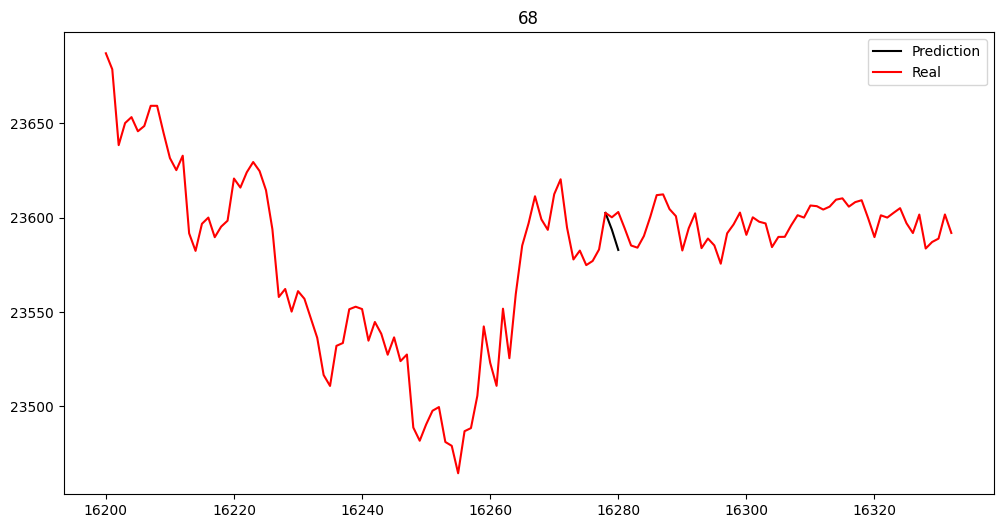

Actual: [23602.6, 23600.25, 23603.05]
prdiction [23602.6, 23593.707521057127, 23582.949617004393]
(16244, 3)
 55/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16243, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16242, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


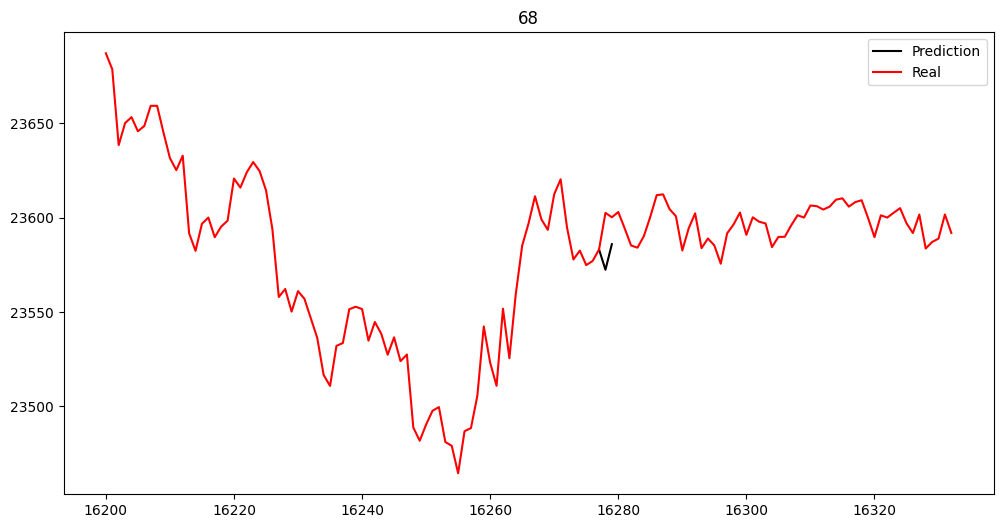

Actual: [23583.2, 23602.6, 23600.25]
prdiction [23583.2, 23572.442095947266, 23586.00667114258]
(16243, 3)
 43/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16242, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16241, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


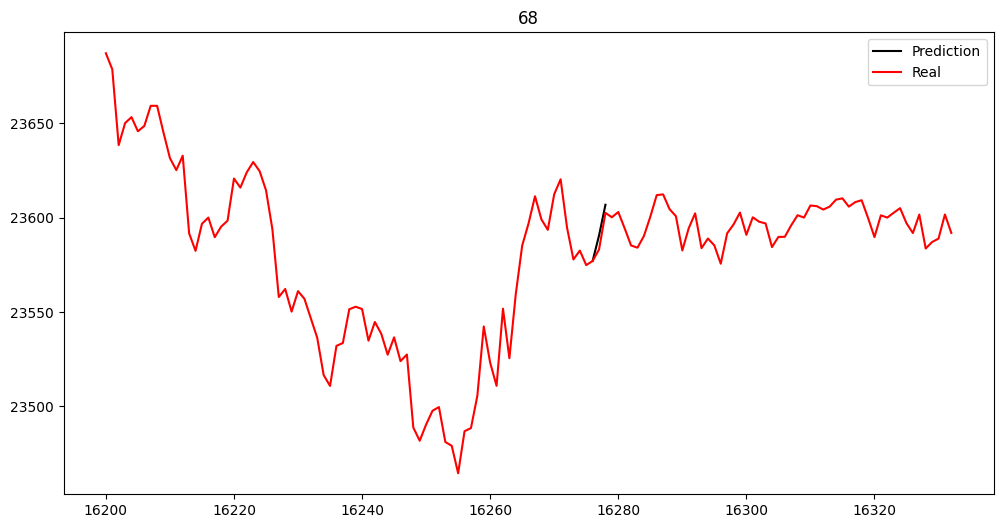

Actual: [23577.1, 23583.2, 23602.6]
prdiction [23577.1, 23590.66457519531, 23606.89930114746]
(16242, 3)
 54/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16241, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16240, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


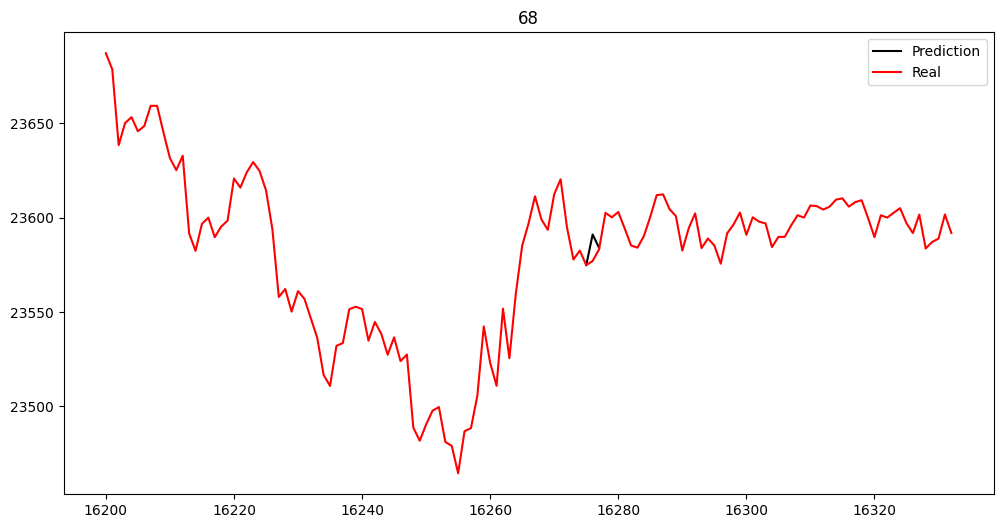

Actual: [23574.9, 23577.1, 23583.2]
prdiction [23574.9, 23591.13472595215, 23584.072401428224]
(16241, 3)
 54/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16240, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16239, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


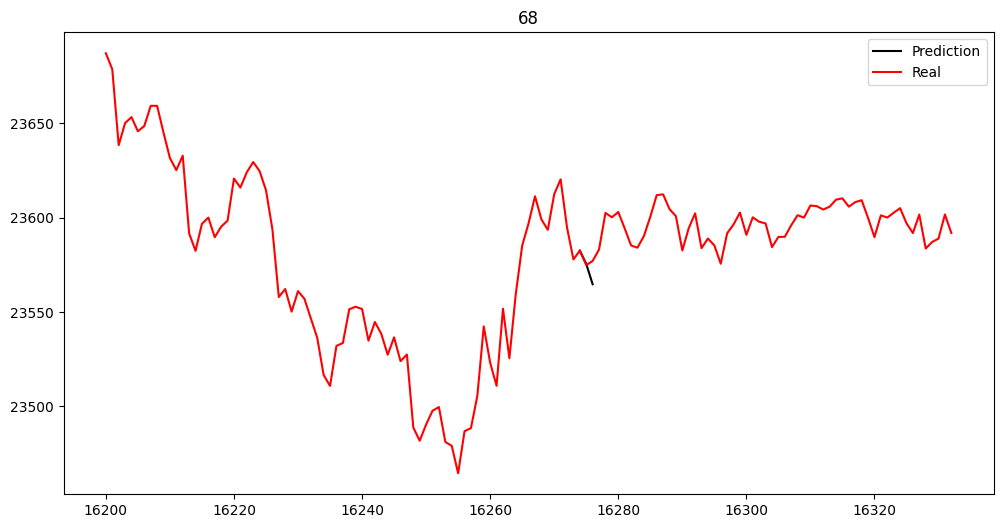

Actual: [23582.6, 23574.9, 23577.1]
prdiction [23582.6, 23575.537675476073, 23564.74514160156]
(16240, 3)
 47/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16239, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16238, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


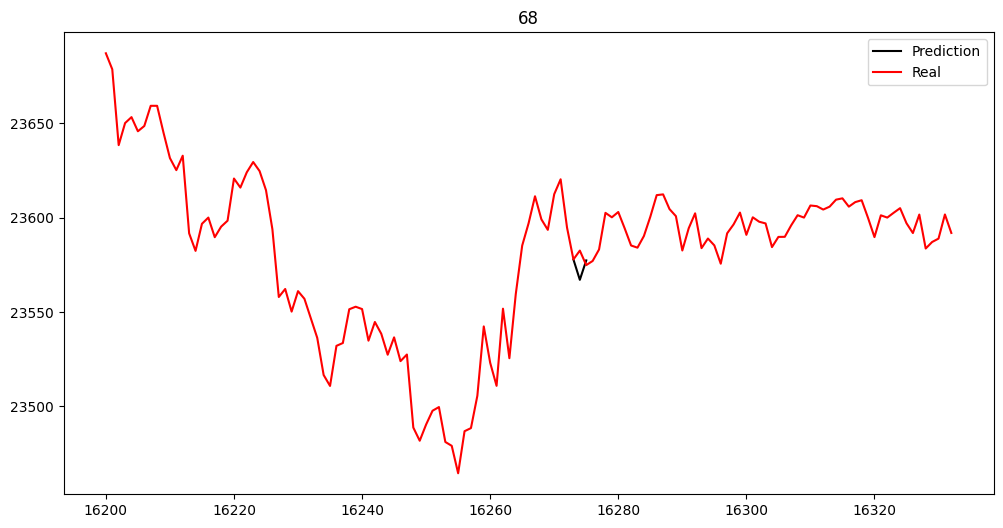

Actual: [23577.9, 23582.6, 23574.9]
prdiction [23577.9, 23567.10746612549, 23577.40562286377]
(16239, 3)
 49/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16238, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16237, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


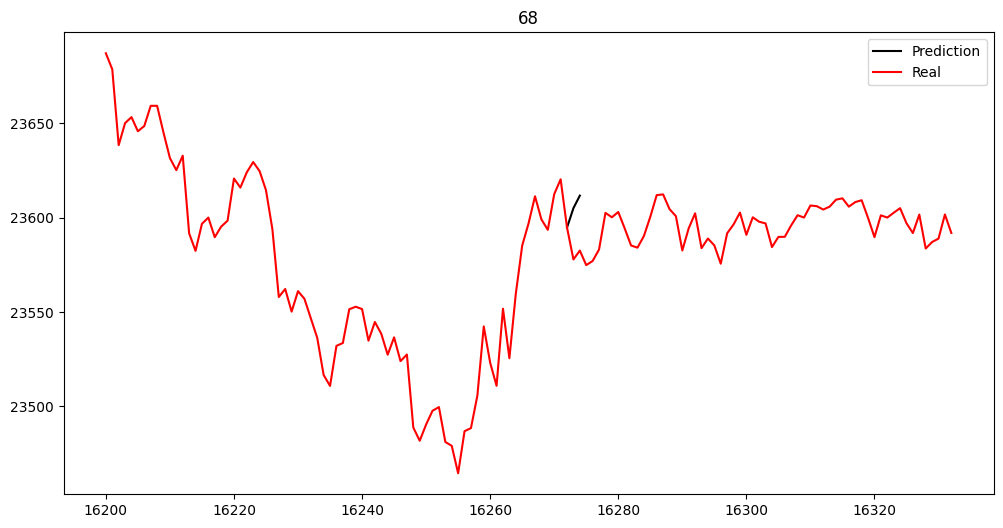

Actual: [23594.8, 23577.9, 23582.6]
prdiction [23594.8, 23605.09815673828, 23611.743954467773]
(16238, 3)
 51/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16237, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16236, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


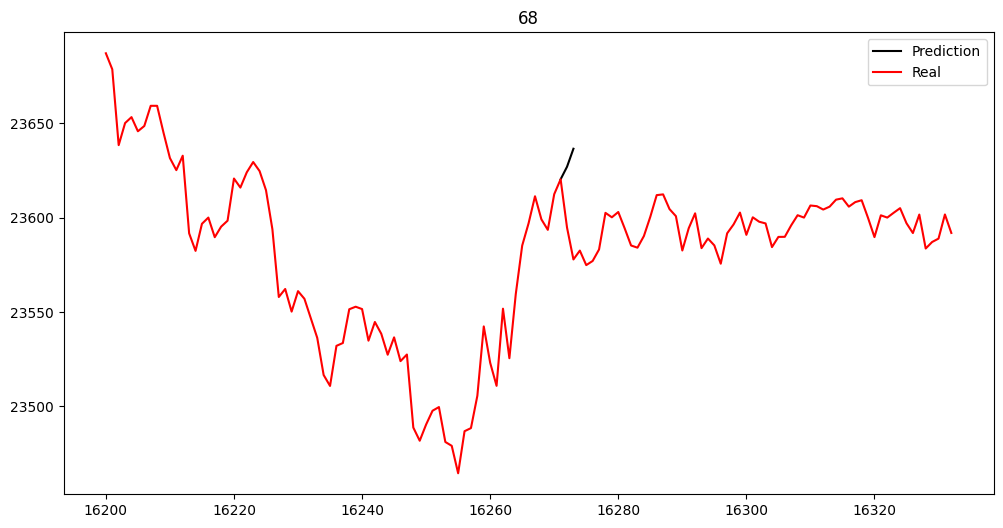

Actual: [23620.4, 23594.8, 23577.9]
prdiction [23620.4, 23627.045797729494, 23636.59387817383]
(16237, 3)
 56/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16236, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16235, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


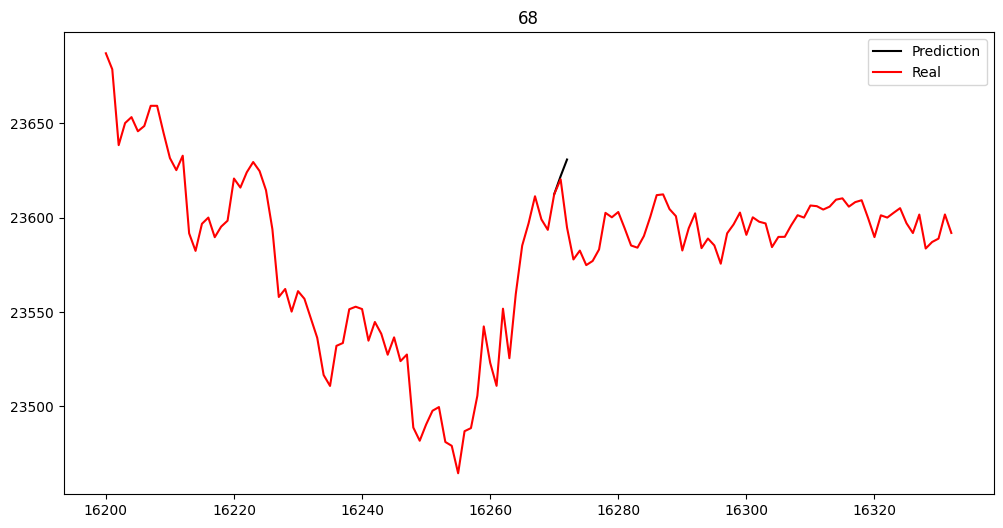

Actual: [23612.5, 23620.4, 23594.8]
prdiction [23612.5, 23622.048080444336, 23630.88205718994]
(16236, 3)
 44/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16235, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16234, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


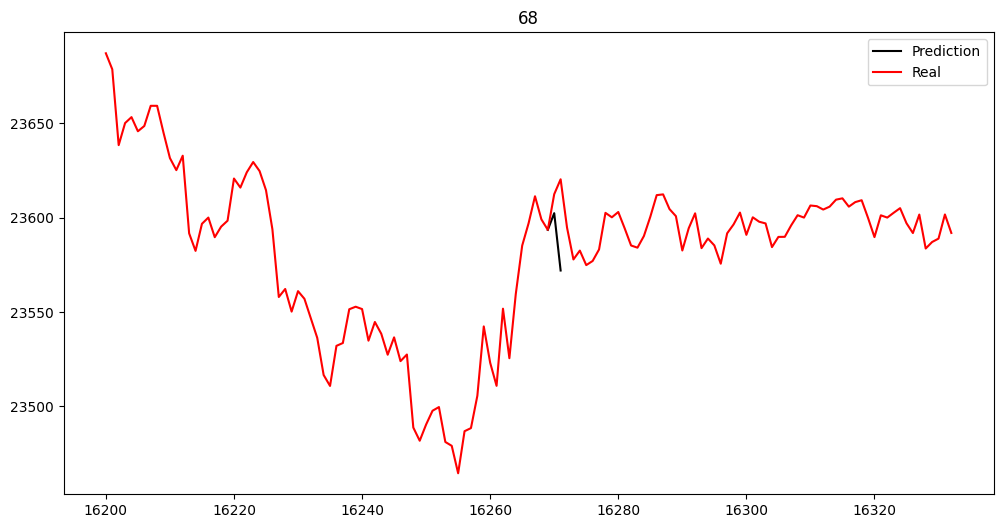

Actual: [23593.6, 23612.5, 23620.4]
prdiction [23593.6, 23602.433976745604, 23572.038407897948]
(16235, 3)
 49/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16234, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16233, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


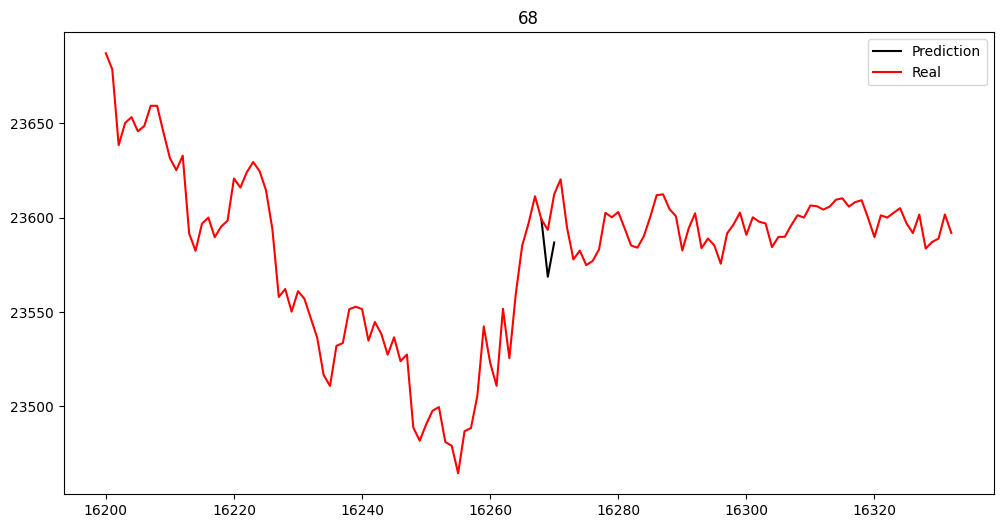

Actual: [23599.15, 23593.6, 23612.5]
prdiction [23599.15, 23568.754431152345, 23586.88344421387]
(16234, 3)
 46/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16233, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16232, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


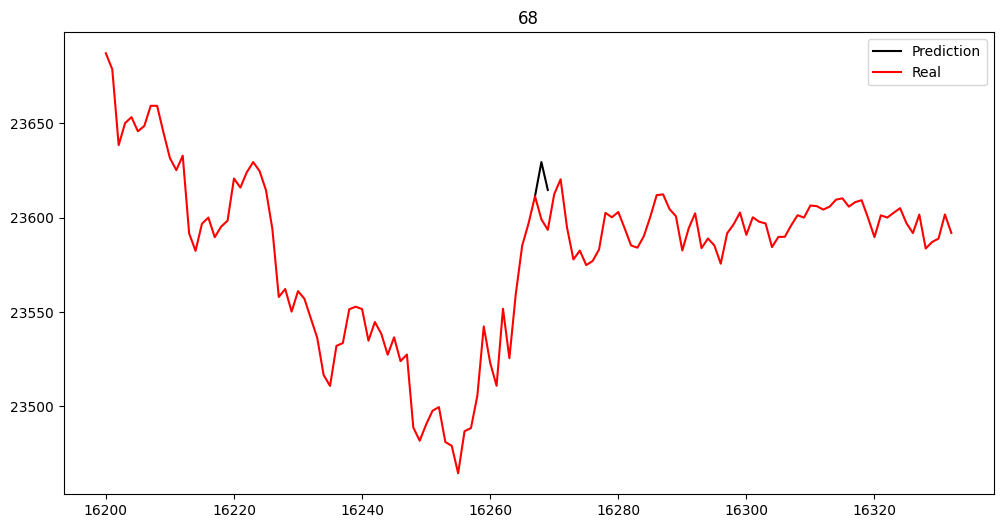

Actual: [23611.4, 23599.15, 23593.6]
prdiction [23611.4, 23629.529013061525, 23614.731230163576]
(16233, 3)
 53/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16232, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16231, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


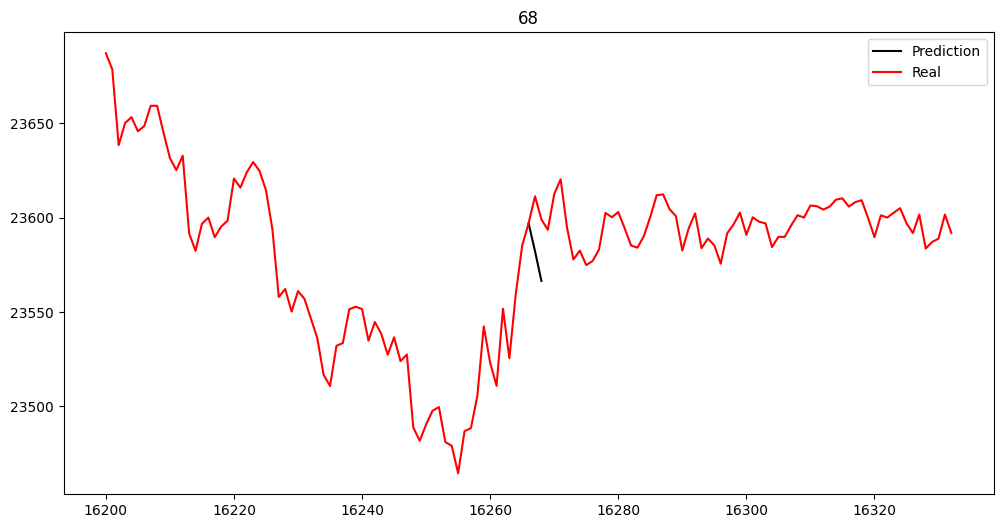

Actual: [23597.1, 23611.4, 23599.15]
prdiction [23597.1, 23582.30221710205, 23566.558274841307]
(16232, 3)
 19/508 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16231, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16230, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


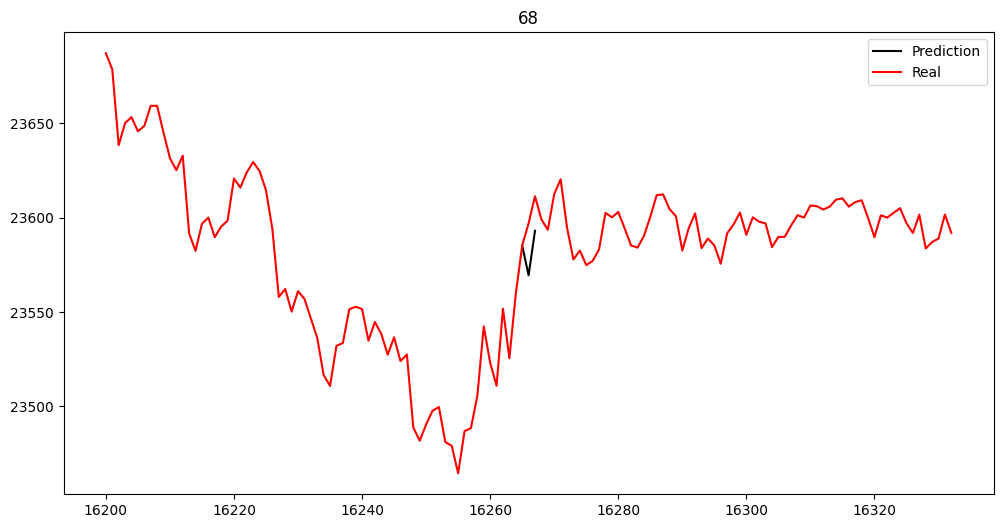

Actual: [23585.25, 23597.1, 23611.4]
prdiction [23585.25, 23569.506057739258, 23593.101455688477]
(16231, 3)
 50/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16230, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16229, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


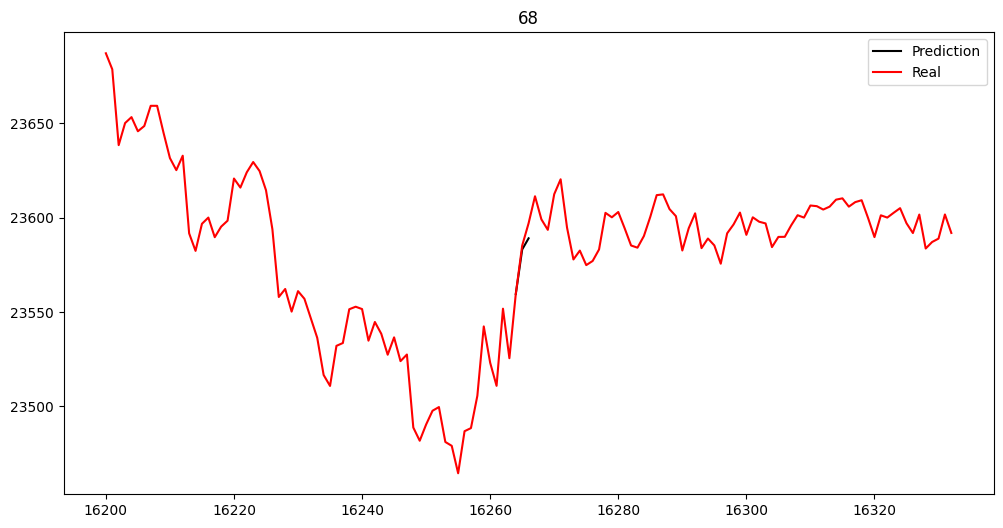

Actual: [23559.6, 23585.25, 23597.1]
prdiction [23559.6, 23583.195397949217, 23589.109796142577]
(16230, 3)
 42/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16229, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16228, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


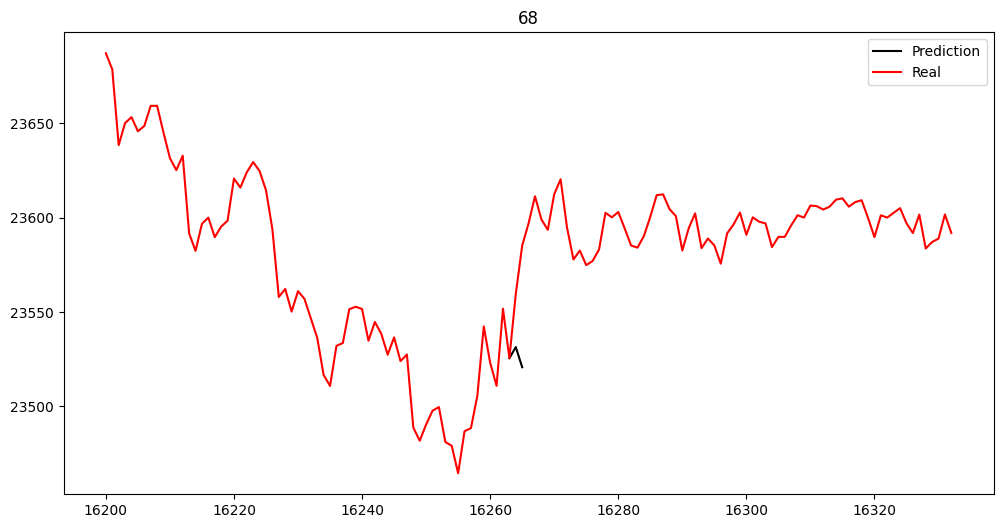

Actual: [23525.55, 23559.6, 23585.25]
prdiction [23525.55, 23531.46439819336, 23520.778866577148]
(16229, 3)
 44/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16228, 3)
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16227, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


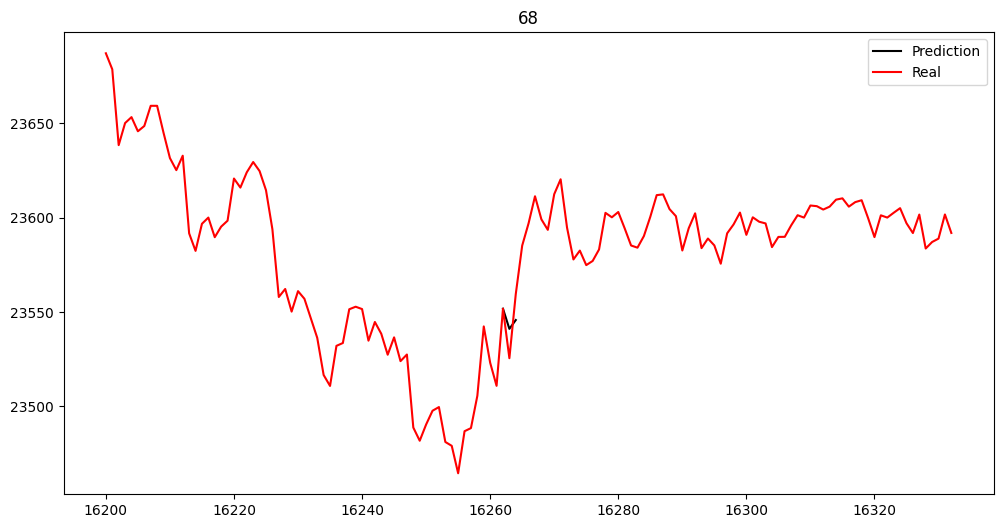

Actual: [23551.8, 23525.55, 23559.6]
prdiction [23551.8, 23541.11446838379, 23545.791722106933]
(16228, 3)
 52/508 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16227, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16226, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


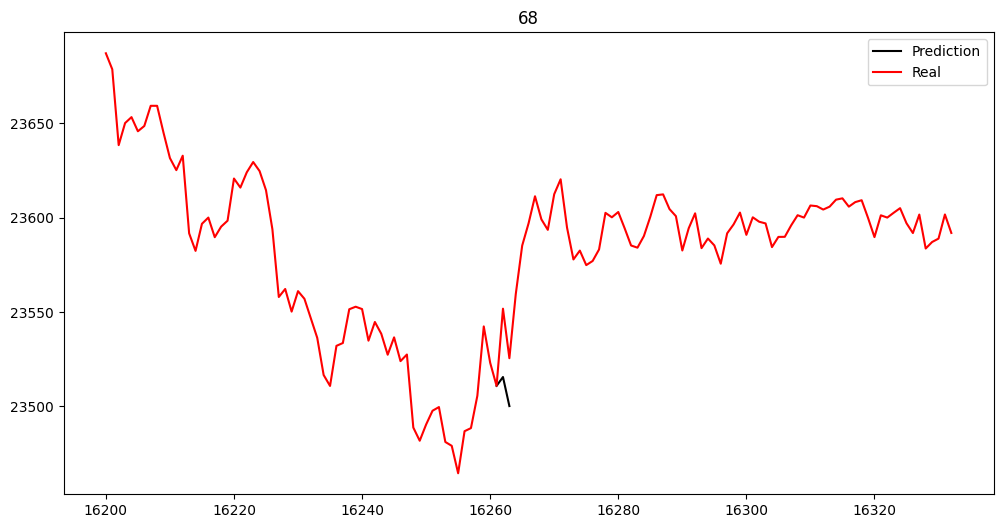

Actual: [23510.9, 23551.8, 23525.55]
prdiction [23510.9, 23515.577253723146, 23500.178861999513]
(16227, 3)
 17/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16226, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16225, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


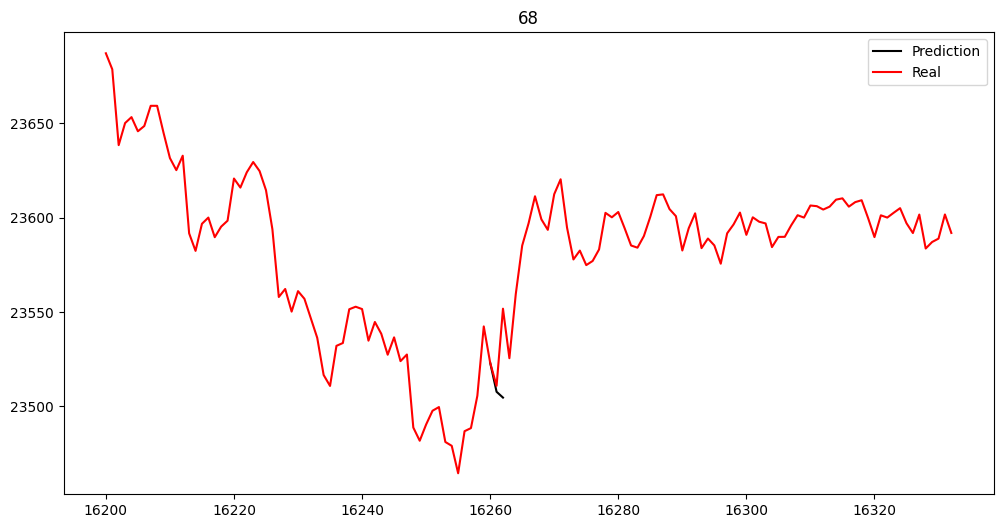

Actual: [23523.15, 23510.9, 23551.8]
prdiction [23523.15, 23507.75160827637, 23504.67254486084]
(16226, 3)
 52/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16225, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16224, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


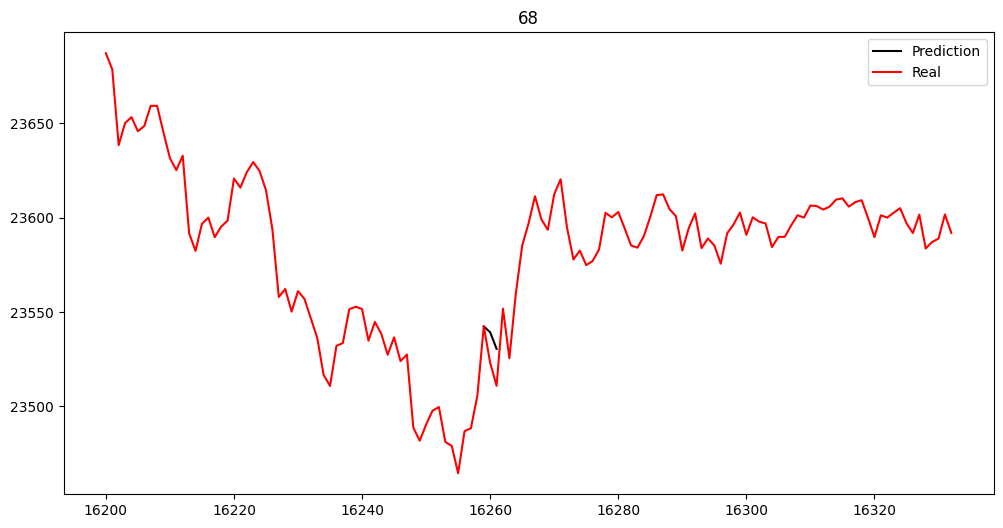

Actual: [23542.4, 23523.15, 23510.9]
prdiction [23542.4, 23539.320936584474, 23530.52023162842]
(16225, 3)
 46/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16224, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16223, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


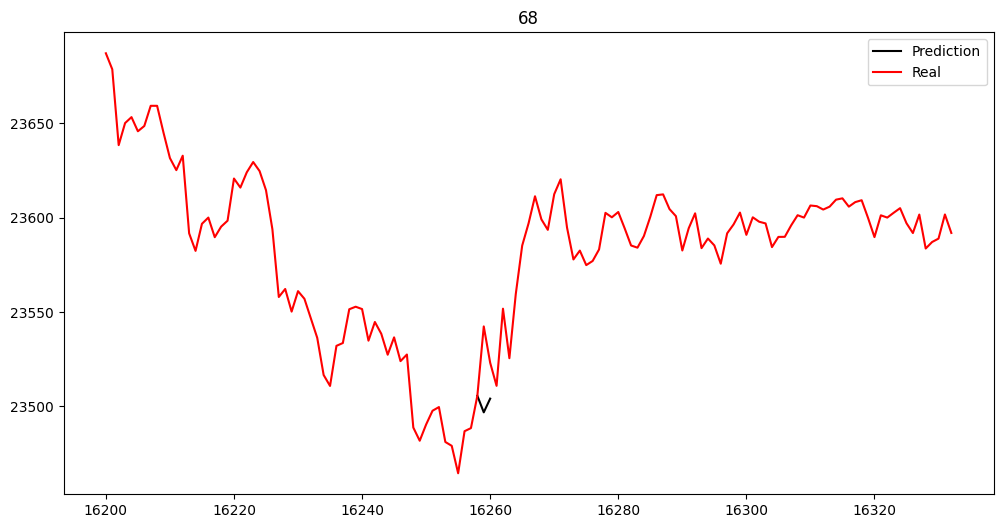

Actual: [23505.65, 23542.4, 23523.15]
prdiction [23505.65, 23496.849295043947, 23504.12248840332]
(16224, 3)
 50/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16223, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16222, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


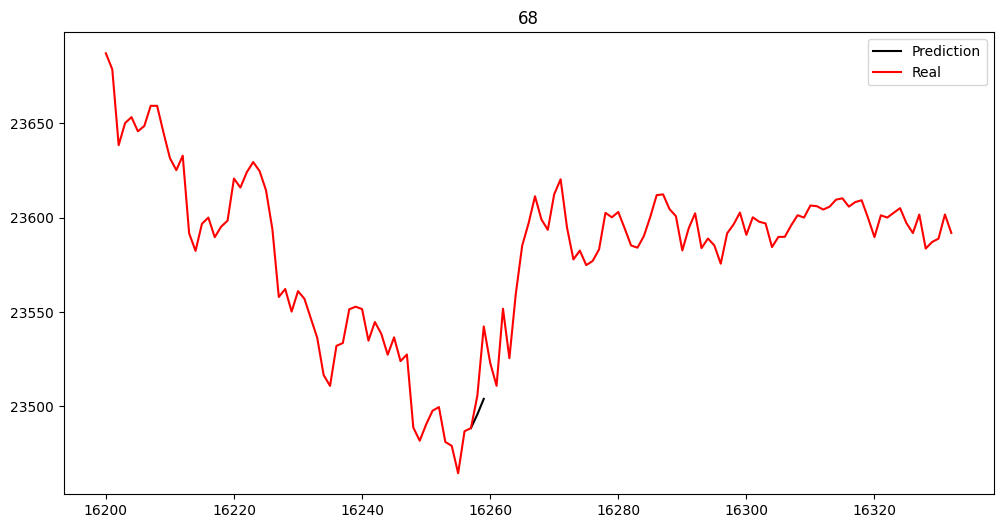

Actual: [23488.5, 23505.65, 23542.4]
prdiction [23488.5, 23495.773193359375, 23503.984657287598]
(16223, 3)
 54/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16222, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16221, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


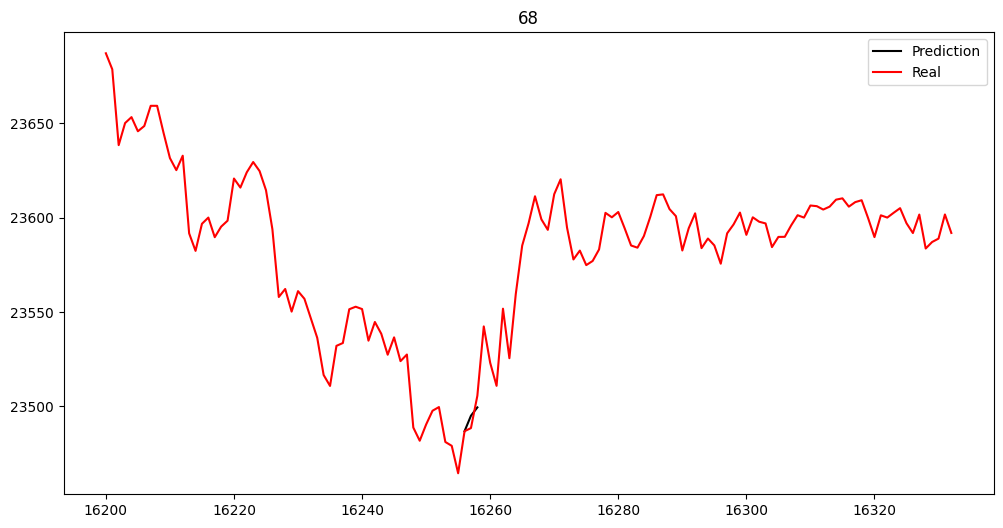

Actual: [23486.85, 23488.5, 23505.65]
prdiction [23486.85, 23495.06146392822, 23499.476342773436]
(16222, 3)
 27/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16221, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16220, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


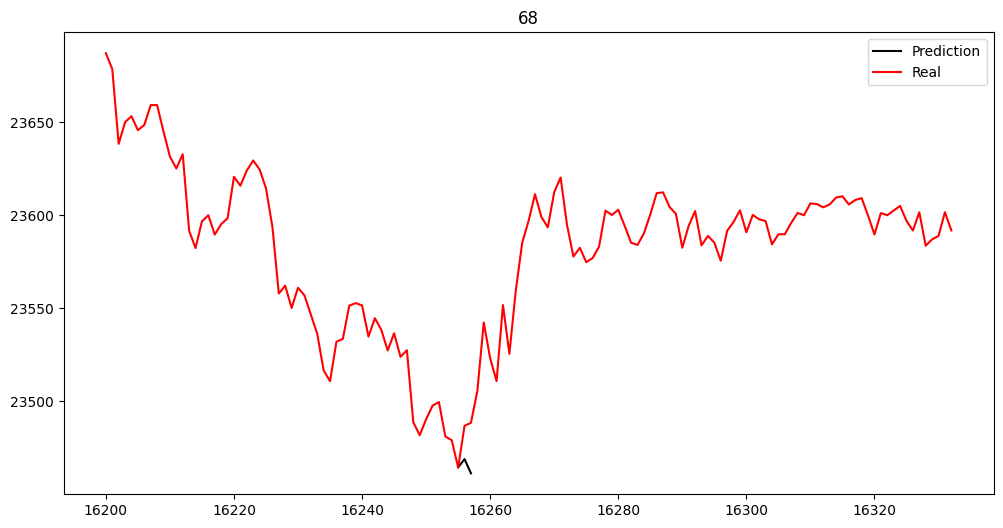

Actual: [23464.55, 23486.85, 23488.5]
prdiction [23464.55, 23468.964878845214, 23461.348164367675]
(16221, 3)
 45/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16220, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16219, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


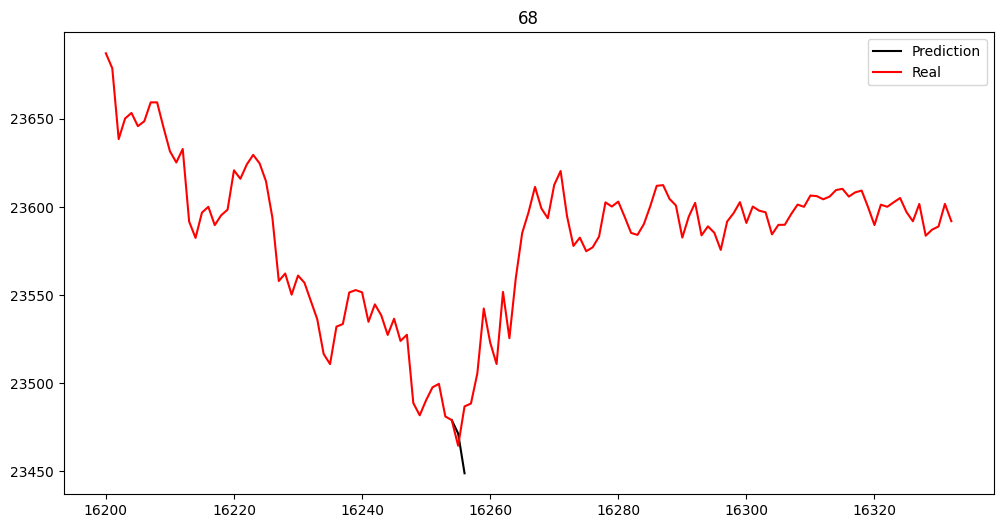

Actual: [23479.1, 23464.55, 23486.85]
prdiction [23479.1, 23471.48328552246, 23448.91735229492]
(16220, 3)
 18/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16219, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16218, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


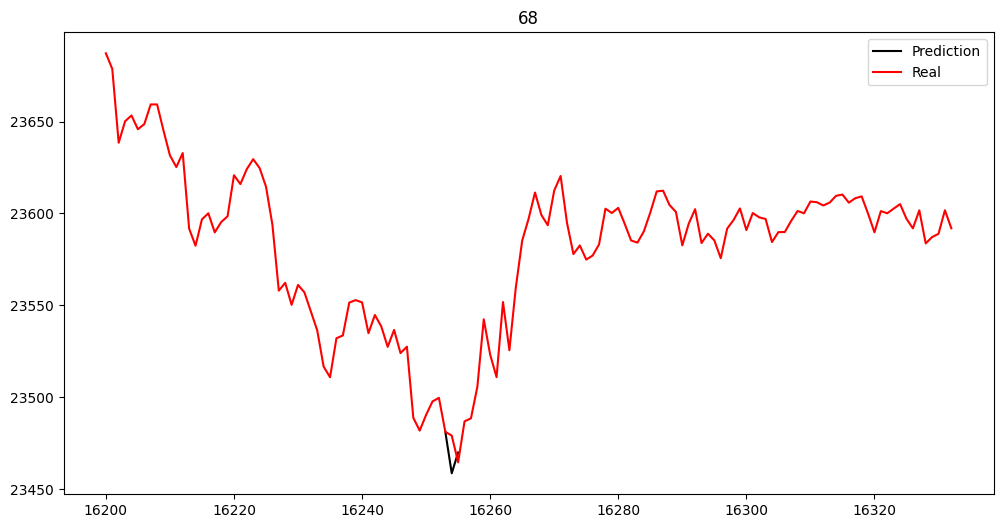

Actual: [23481.15, 23479.1, 23464.55]
prdiction [23481.15, 23458.584066772462, 23469.91222229004]
(16219, 3)
 25/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16218, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16217, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


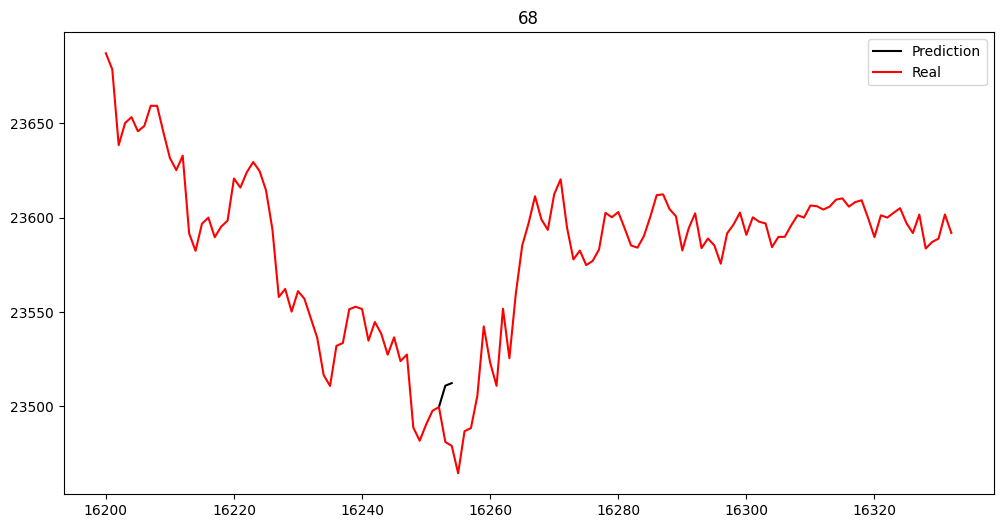

Actual: [23499.65, 23481.15, 23479.1]
prdiction [23499.65, 23510.97815551758, 23512.341650390626]
(16218, 3)
 25/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16217, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16216, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


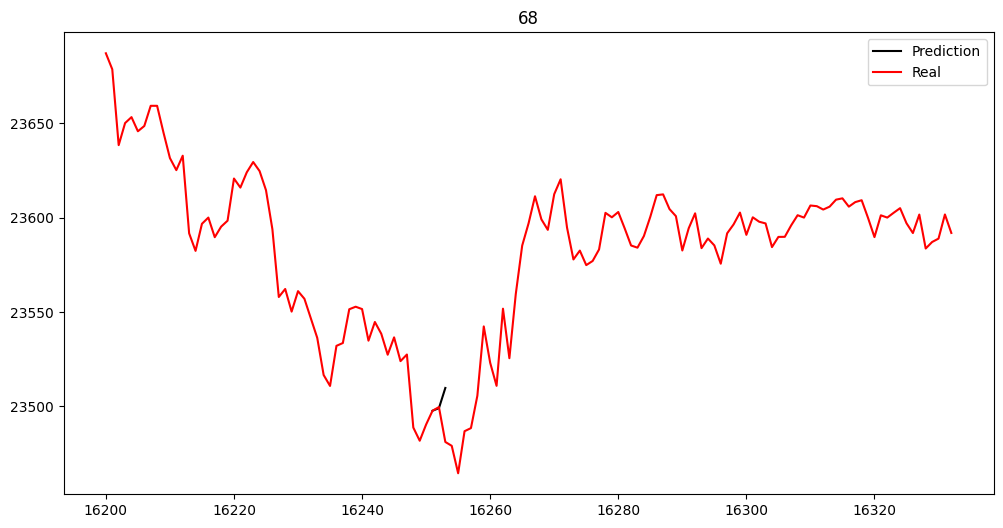

Actual: [23497.7, 23499.65, 23481.15]
prdiction [23497.7, 23499.063494873048, 23509.775187683106]
(16217, 3)
 52/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16216, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16215, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


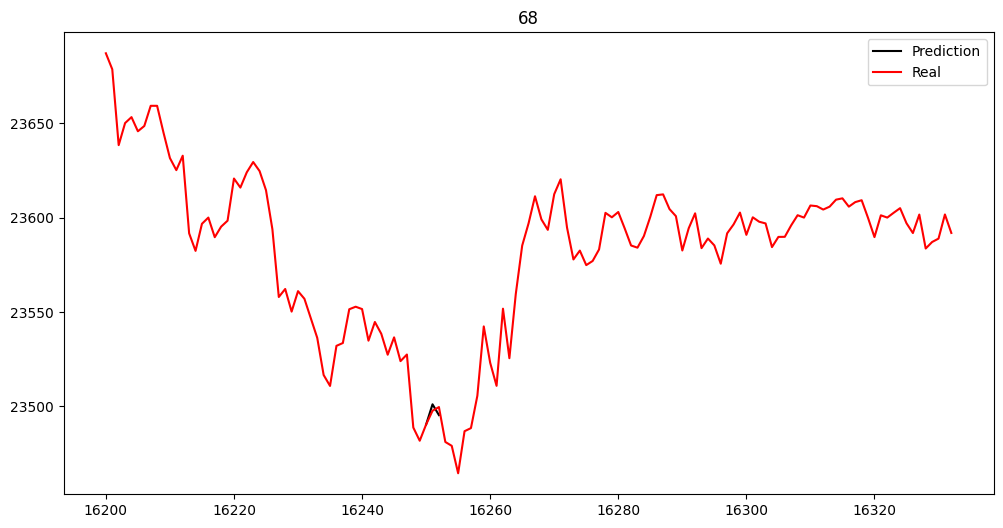

Actual: [23490.4, 23497.7, 23499.65]
prdiction [23490.4, 23501.11169281006, 23495.390646362306]
(16216, 3)
 47/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16215, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16214, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


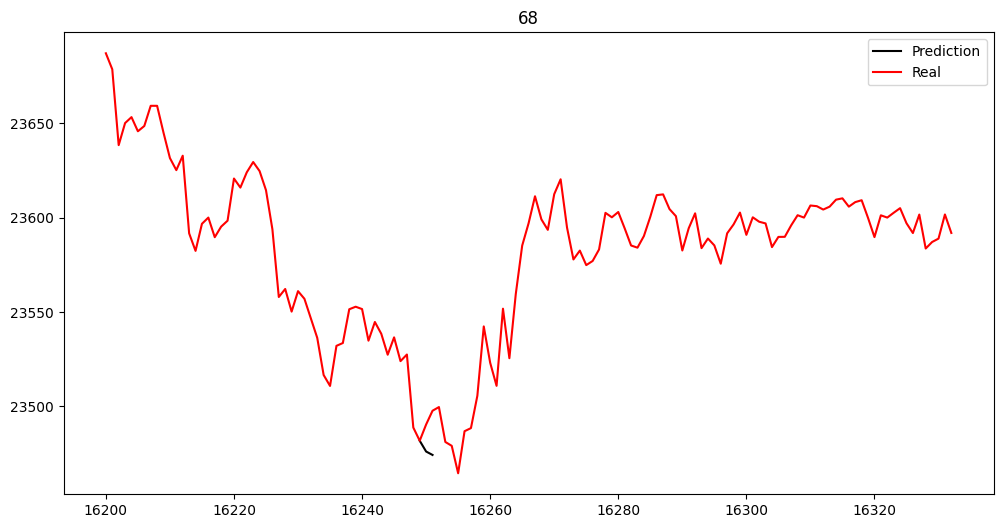

Actual: [23481.8, 23490.4, 23497.7]
prdiction [23481.8, 23476.078953552245, 23474.27451019287]
(16215, 3)
 51/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16214, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16213, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


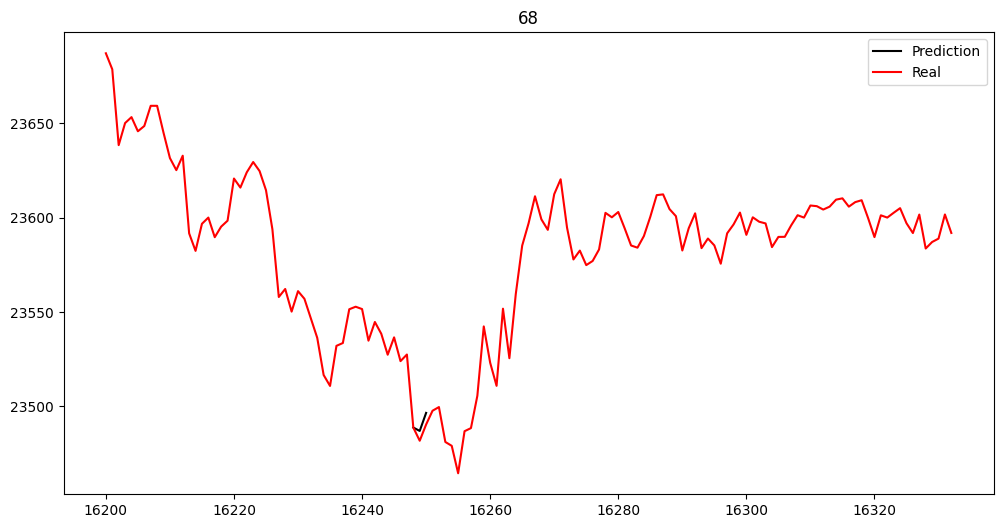

Actual: [23488.8, 23481.8, 23490.4]
prdiction [23488.8, 23486.995556640624, 23496.565411376952]
(16214, 3)
 19/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16213, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16212, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


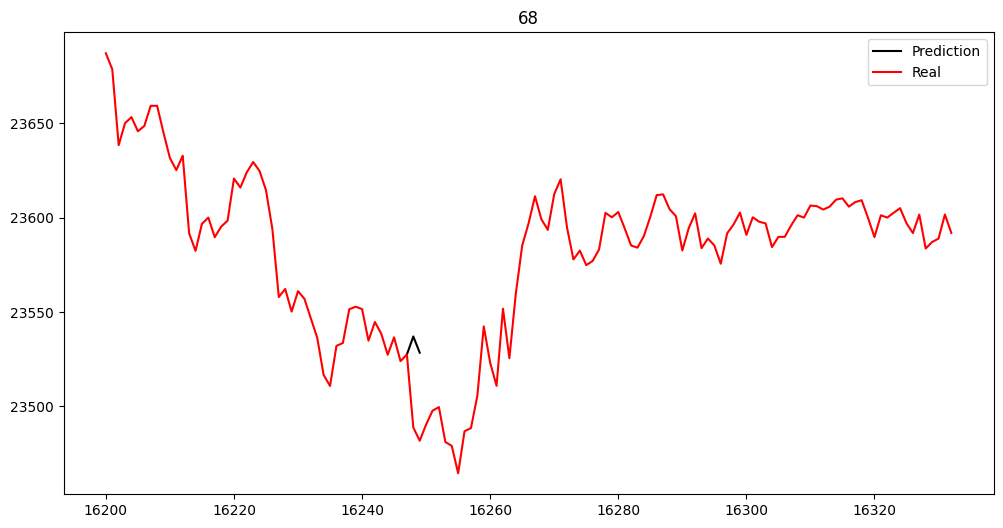

Actual: [23527.5, 23488.8, 23481.8]
prdiction [23527.5, 23537.069854736328, 23528.488174438477]
(16213, 3)
 47/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16212, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16211, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


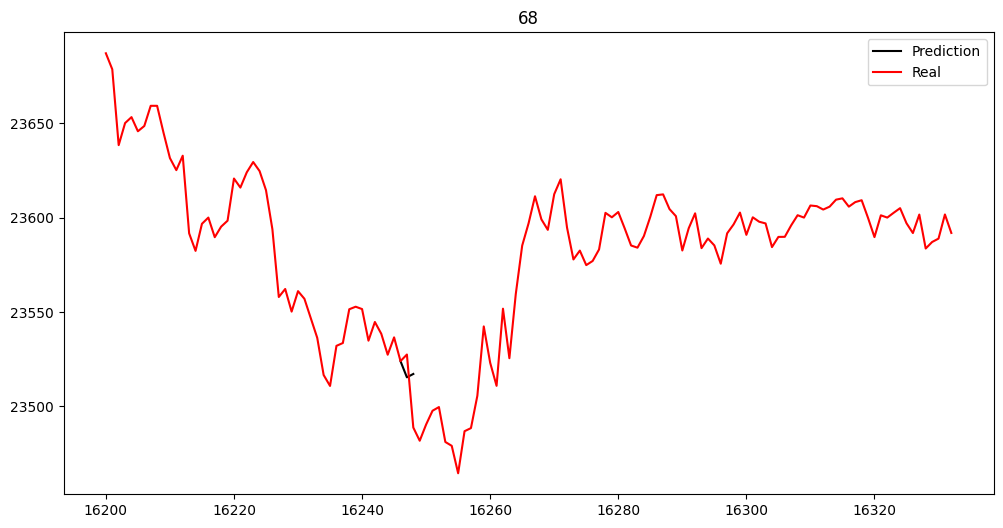

Actual: [23524.0, 23527.5, 23488.8]
prdiction [23524.0, 23515.41831970215, 23517.203094482422]
(16212, 3)
 26/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16211, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16210, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


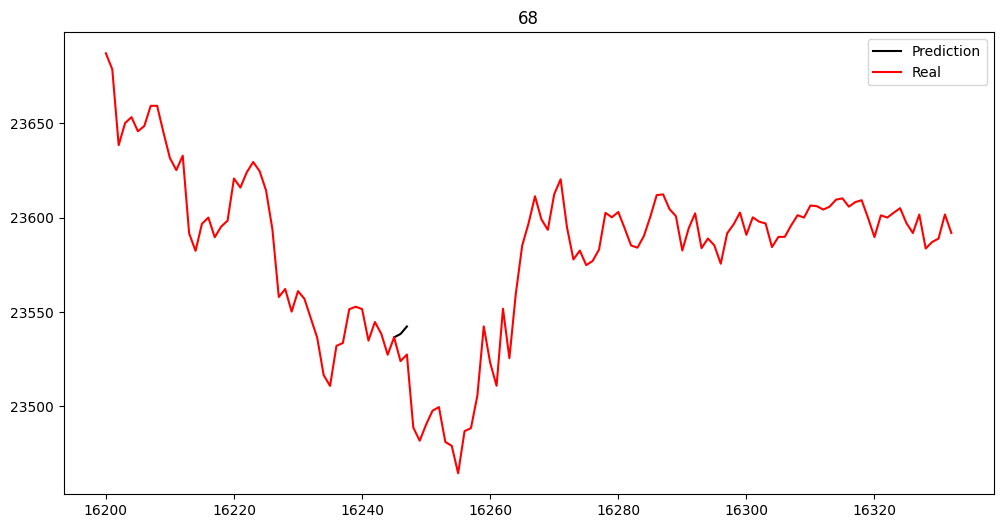

Actual: [23536.6, 23524.0, 23527.5]
prdiction [23536.6, 23538.384774780272, 23542.370668029784]
(16211, 3)
 26/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16210, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16209, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


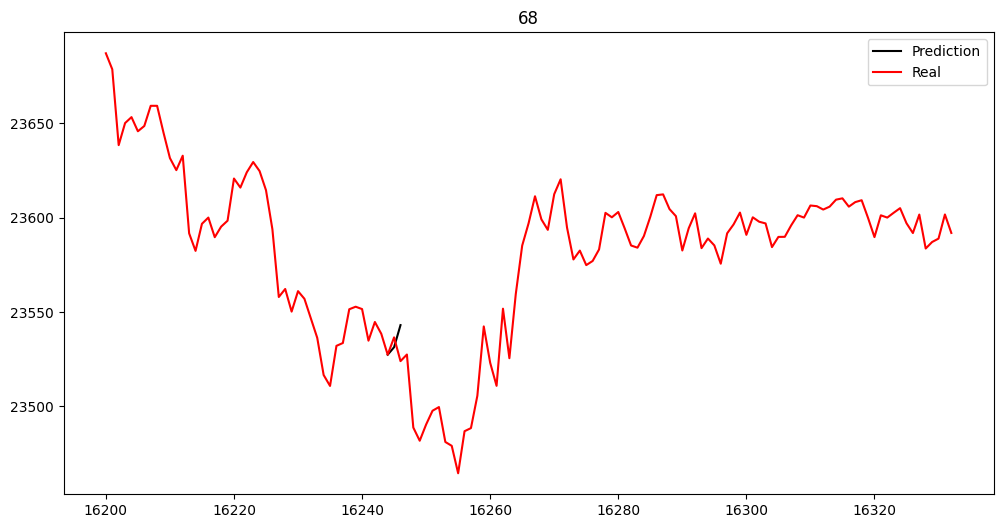

Actual: [23527.4, 23536.6, 23524.0]
prdiction [23527.4, 23531.385893249513, 23543.097257995607]
(16210, 3)
 26/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16209, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16208, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


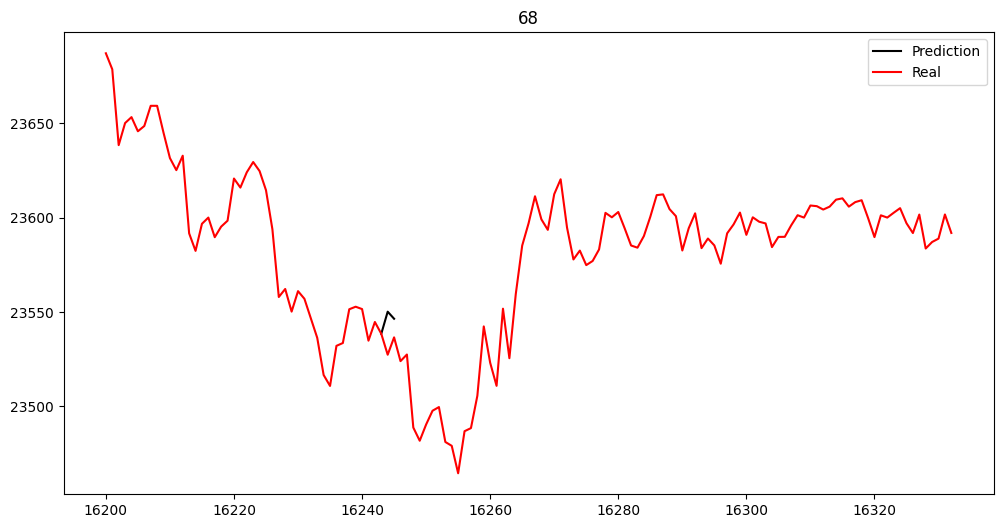

Actual: [23538.5, 23527.4, 23536.6]
prdiction [23538.5, 23550.211364746094, 23546.466247558594]
(16209, 3)
 51/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16208, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16207, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


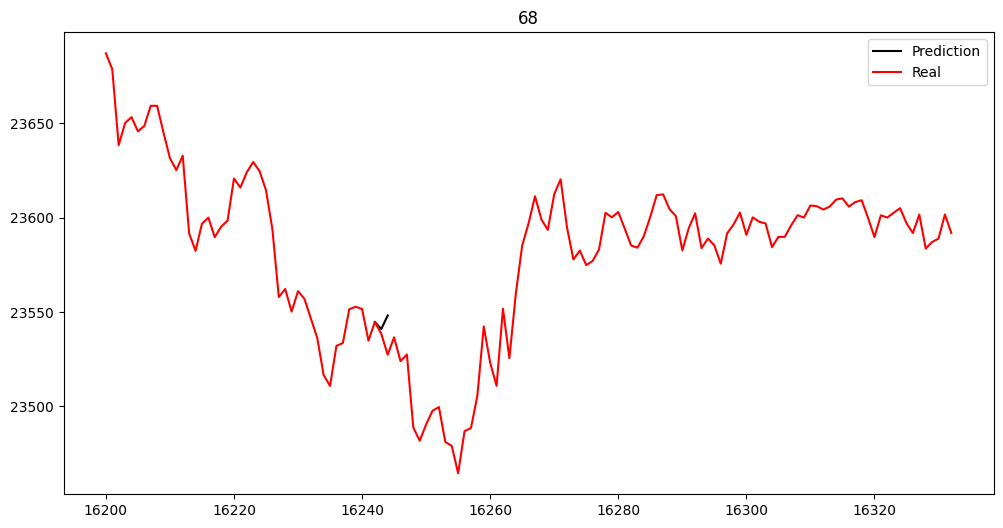

Actual: [23544.75, 23538.5, 23527.4]
prdiction [23544.75, 23541.0048828125, 23548.208473205566]
(16208, 3)
 15/507 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16207, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16206, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


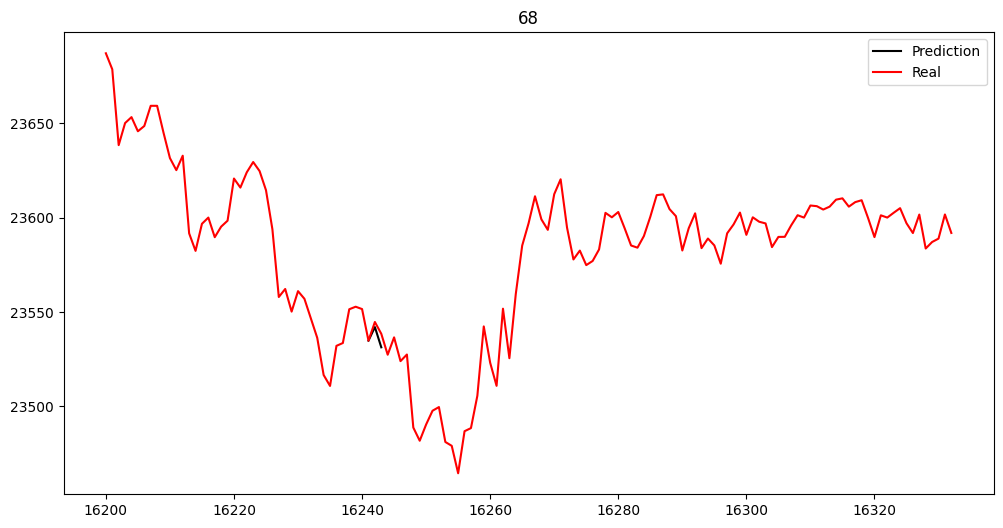

Actual: [23534.85, 23544.75, 23538.5]
prdiction [23534.85, 23542.053590393065, 23531.32148132324]
(16207, 3)
 24/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16206, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16205, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


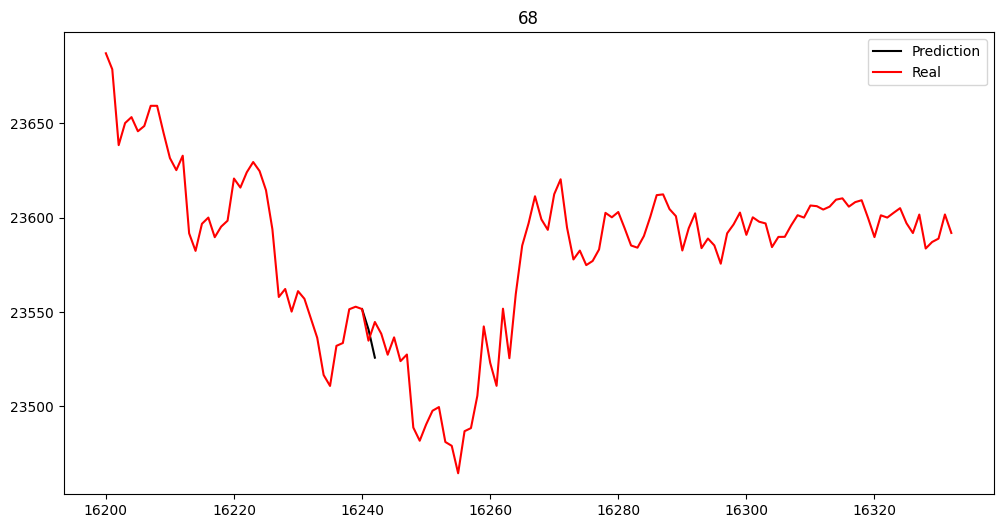

Actual: [23551.6, 23534.85, 23544.75]
prdiction [23551.6, 23540.867890930174, 23525.839669799803]
(16206, 3)
  1/507 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16205, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16204, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


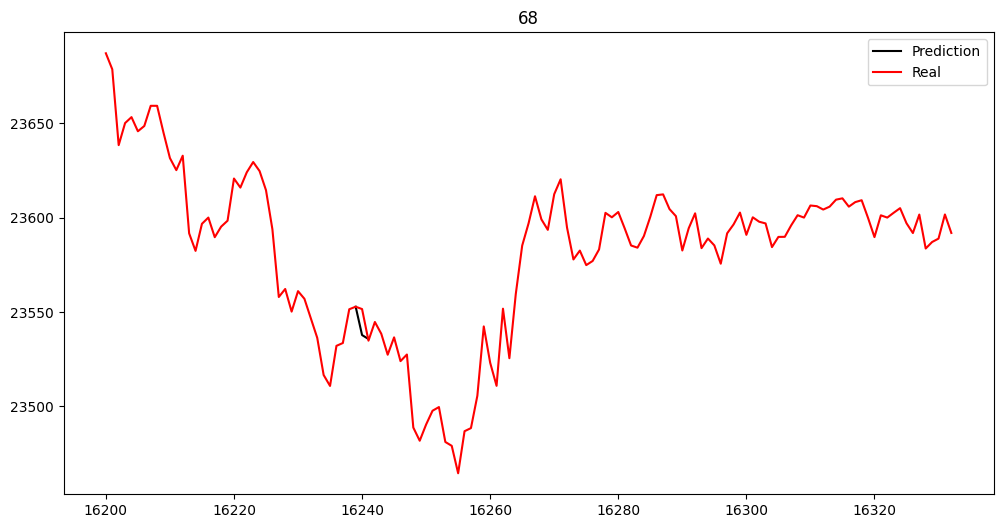

Actual: [23552.85, 23551.6, 23534.85]
prdiction [23552.85, 23537.821778869627, 23535.723985290526]
(16205, 3)
 48/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16204, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16203, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


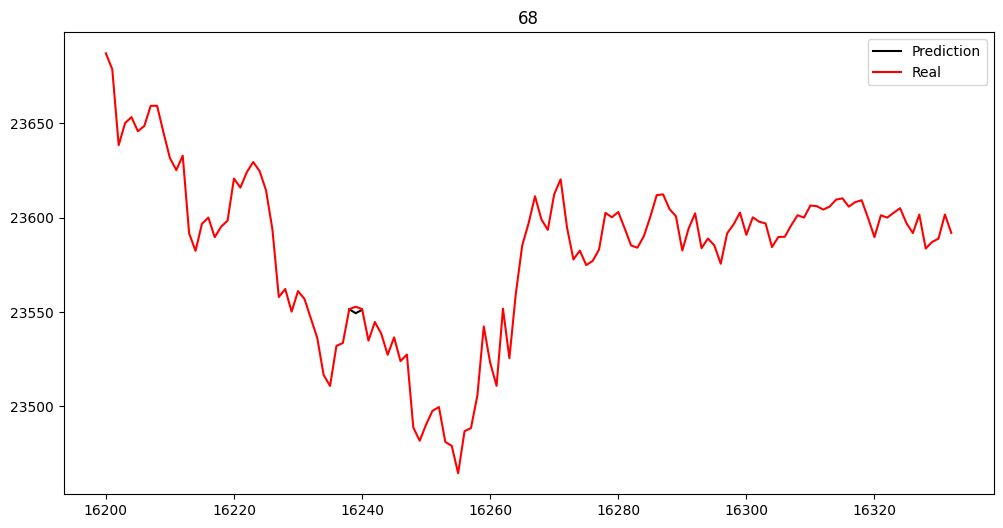

Actual: [23551.5, 23552.85, 23551.6]
prdiction [23551.5, 23549.4022064209, 23551.196060180664]
(16204, 3)
 28/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16203, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16202, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


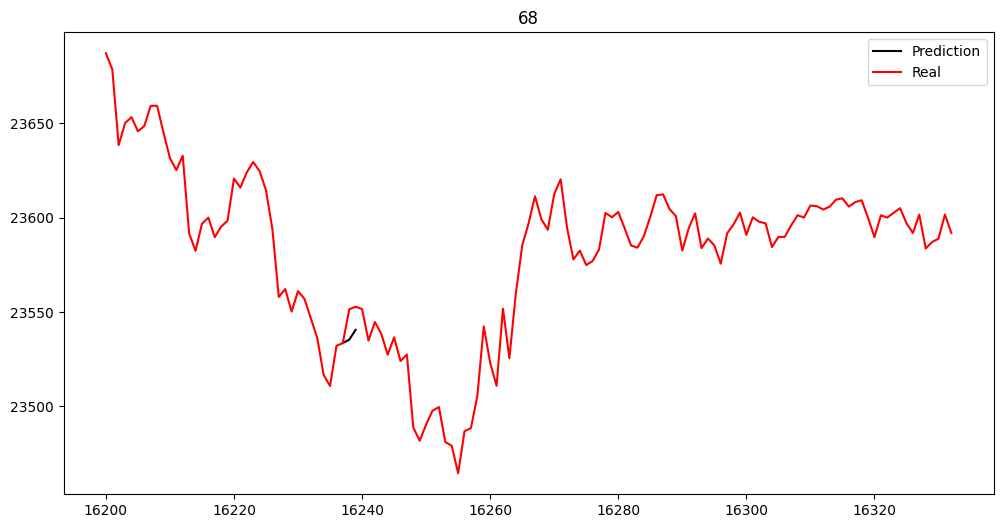

Actual: [23533.6, 23551.5, 23552.85]
prdiction [23533.6, 23535.393853759764, 23540.591775512694]
(16203, 3)
 14/507 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16202, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16201, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


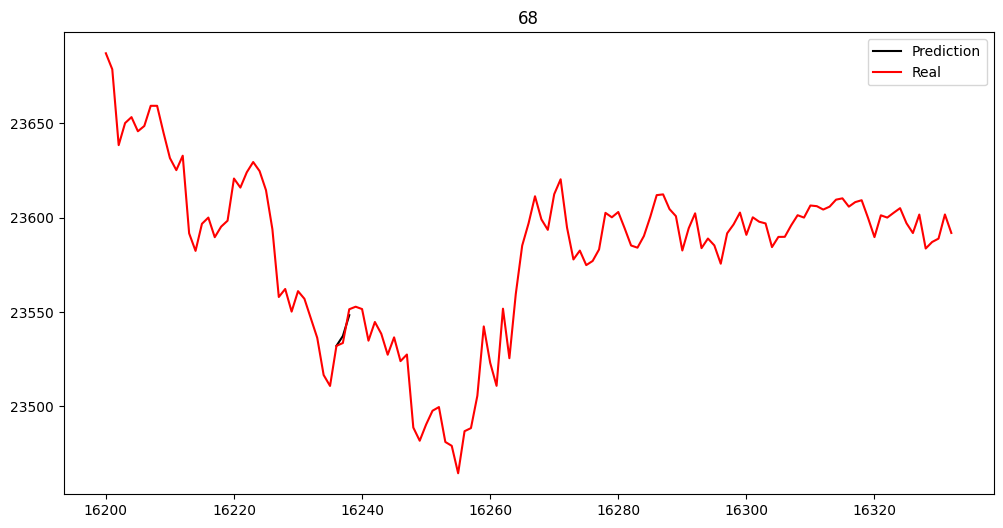

Actual: [23532.1, 23533.6, 23551.5]
prdiction [23532.1, 23537.29792175293, 23548.356454467772]
(16202, 3)
 45/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16201, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16200, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


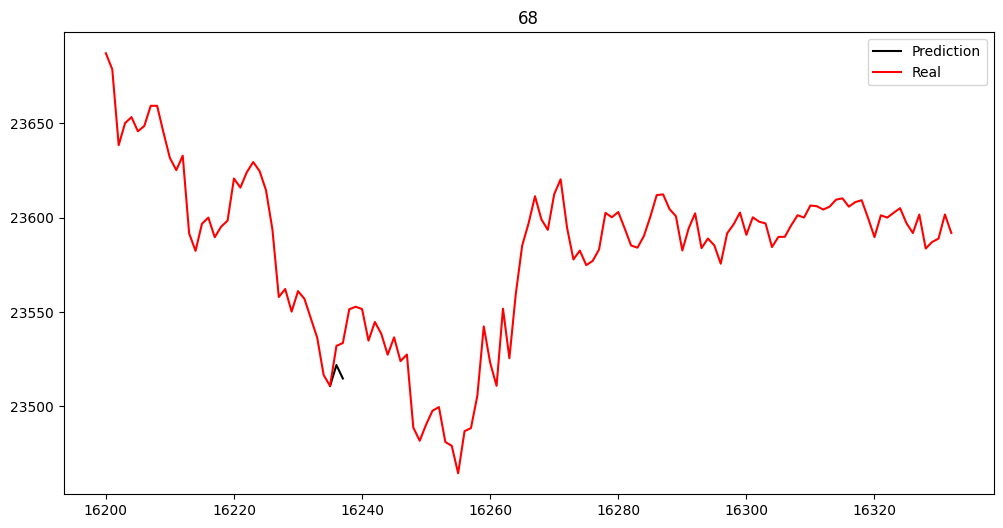

Actual: [23510.85, 23532.1, 23533.6]
prdiction [23510.85, 23521.908532714842, 23514.793405151366]
(16201, 3)
 17/507 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16200, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16199, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


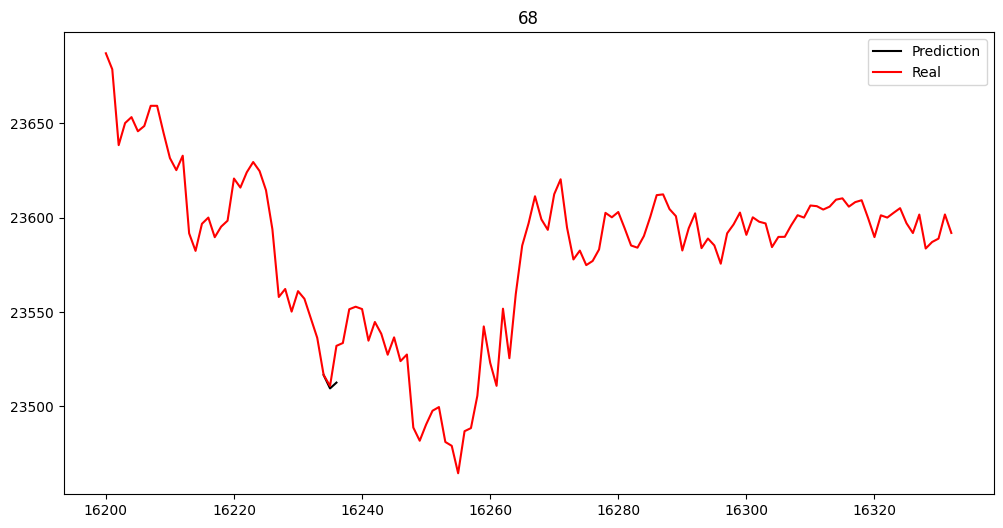

Actual: [23516.65, 23510.85, 23532.1]
prdiction [23516.65, 23509.534872436525, 23512.615103149416]
(16200, 3)
 26/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16199, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16198, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


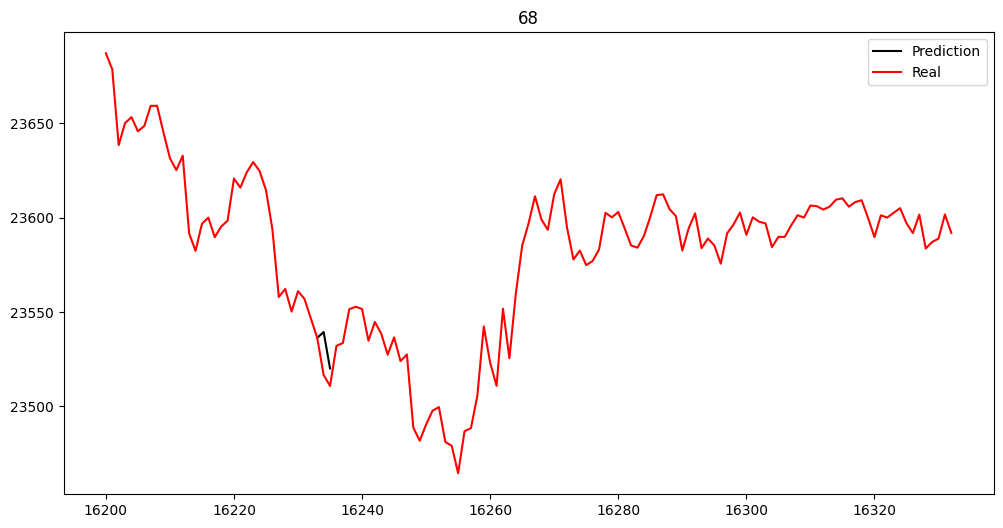

Actual: [23536.35, 23516.65, 23510.85]
prdiction [23536.35, 23539.43023071289, 23520.118630981444]
(16199, 3)
 17/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16198, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16197, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


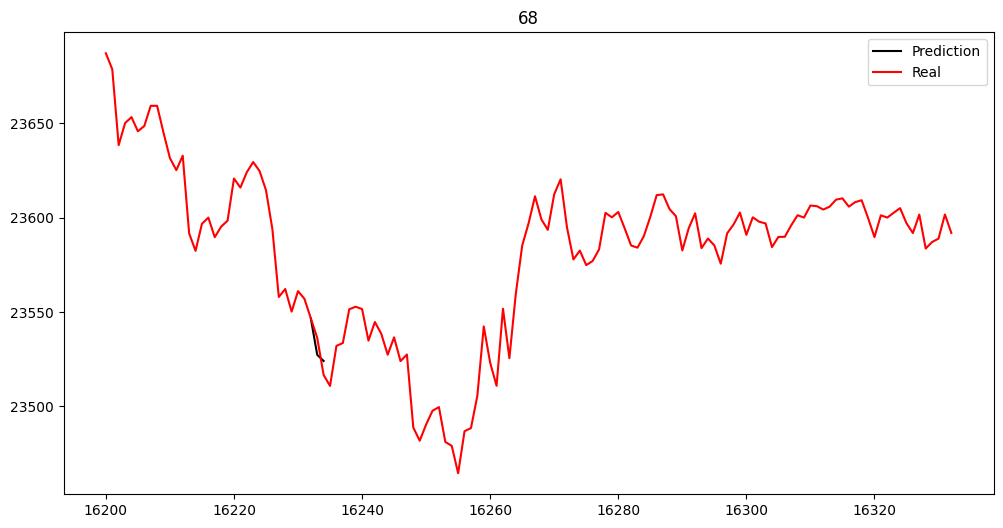

Actual: [23546.65, 23536.35, 23516.65]
prdiction [23546.65, 23527.338400268556, 23524.082556152345]
(16198, 3)
 49/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16197, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16196, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


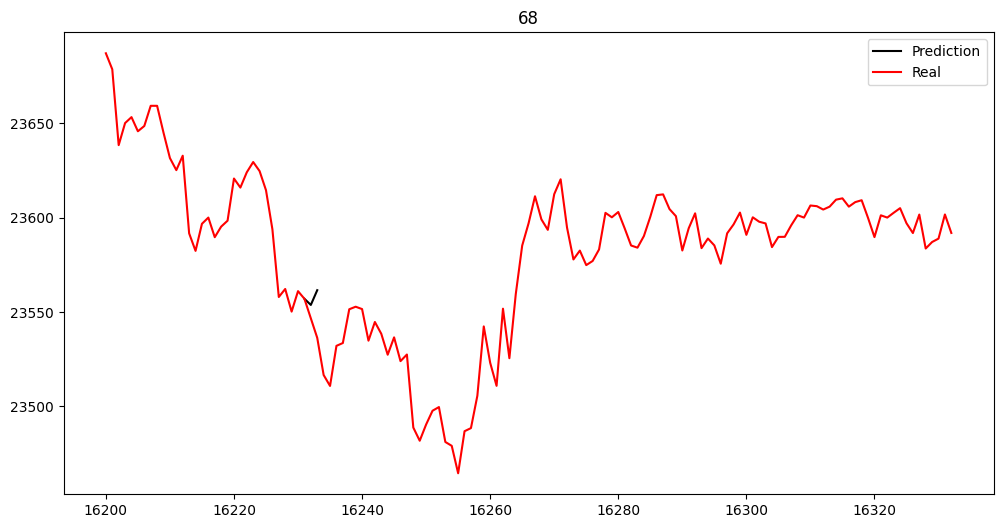

Actual: [23557.05, 23546.65, 23536.35]
prdiction [23557.05, 23553.79415588379, 23561.60467224121]
(16197, 3)
 26/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16196, 3)
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16195, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


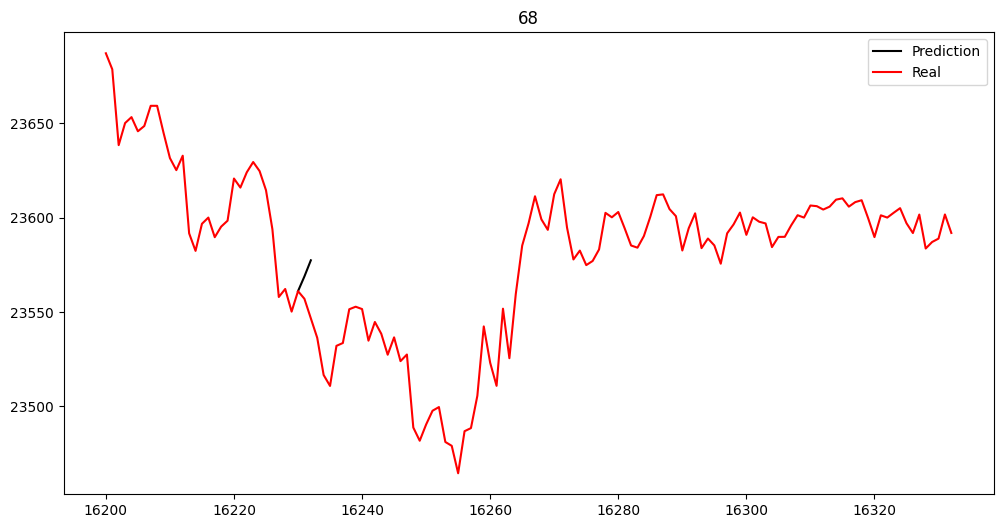

Actual: [23561.1, 23557.05, 23546.65]
prdiction [23561.1, 23568.91051635742, 23577.45368347168]
(16196, 3)
 24/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16195, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16194, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


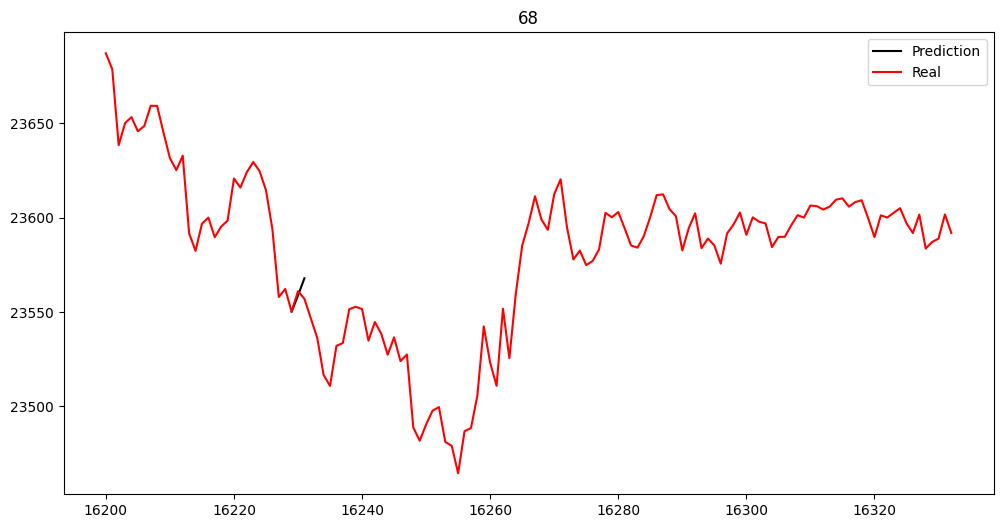

Actual: [23550.25, 23561.1, 23557.05]
prdiction [23550.25, 23558.793167114258, 23567.938552856445]
(16195, 3)
 46/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16194, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16193, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


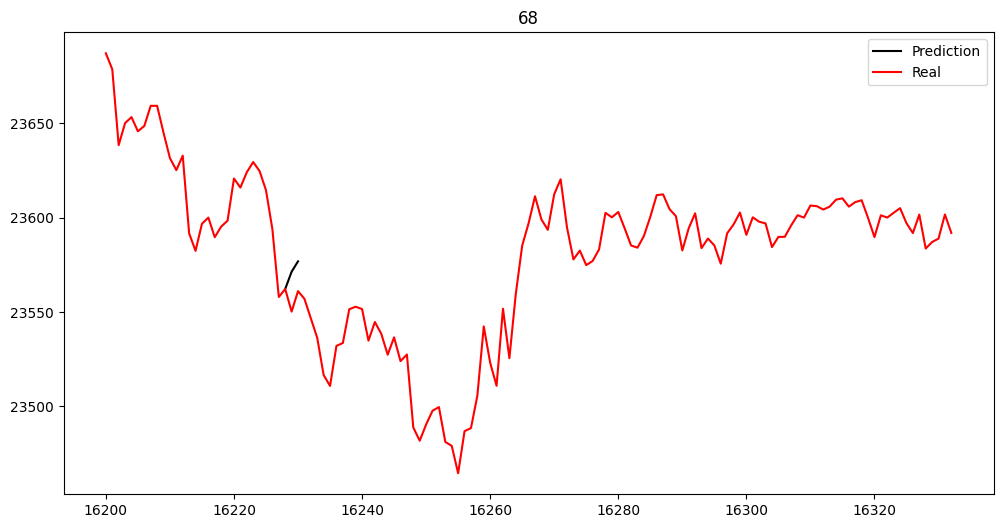

Actual: [23562.25, 23550.25, 23561.1]
prdiction [23562.25, 23571.395385742188, 23576.886001586914]
(16194, 3)
 26/506 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16193, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16192, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


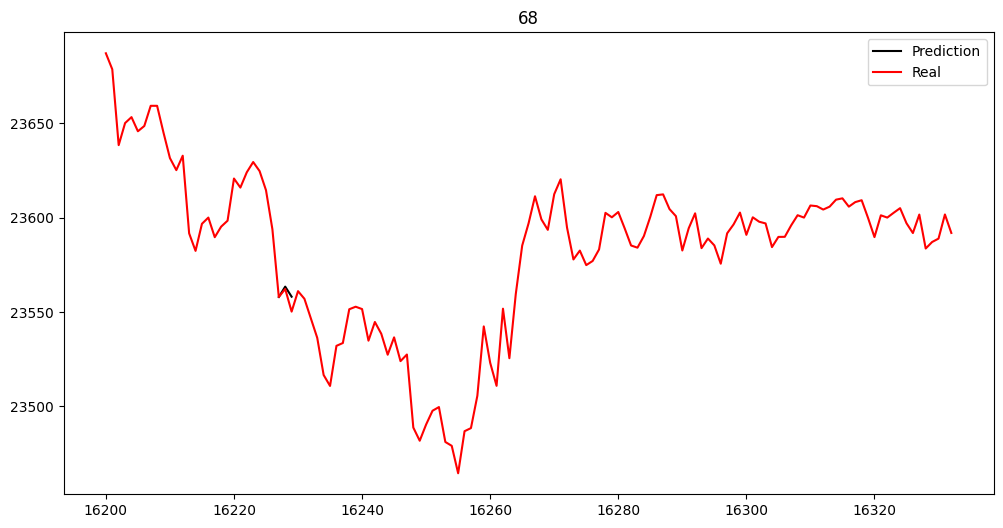

Actual: [23558.0, 23562.25, 23550.25]
prdiction [23558.0, 23563.490615844727, 23558.163345336914]
(16193, 3)
 49/506 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16192, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16191, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


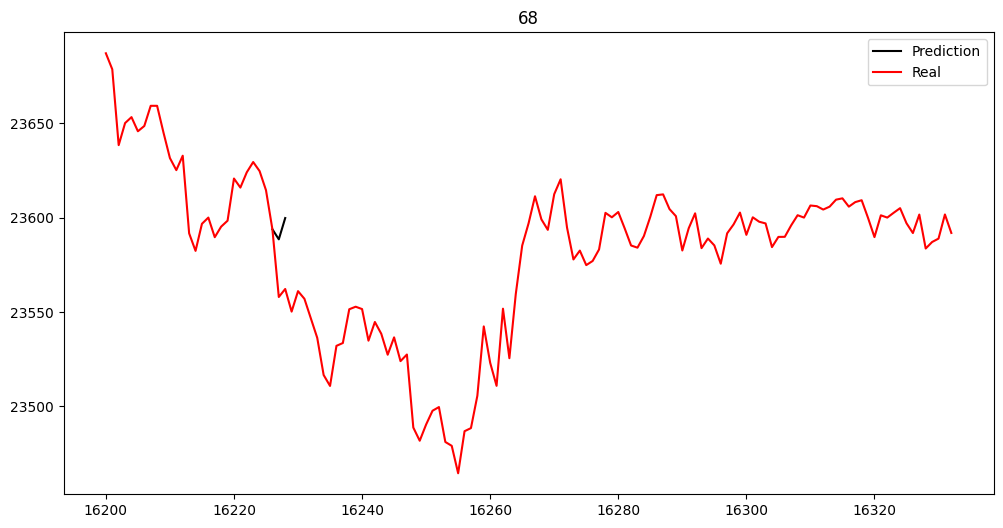

Actual: [23593.9, 23558.0, 23562.25]
prdiction [23593.9, 23588.57272949219, 23599.85211029053]
(16192, 3)
 24/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16191, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16190, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


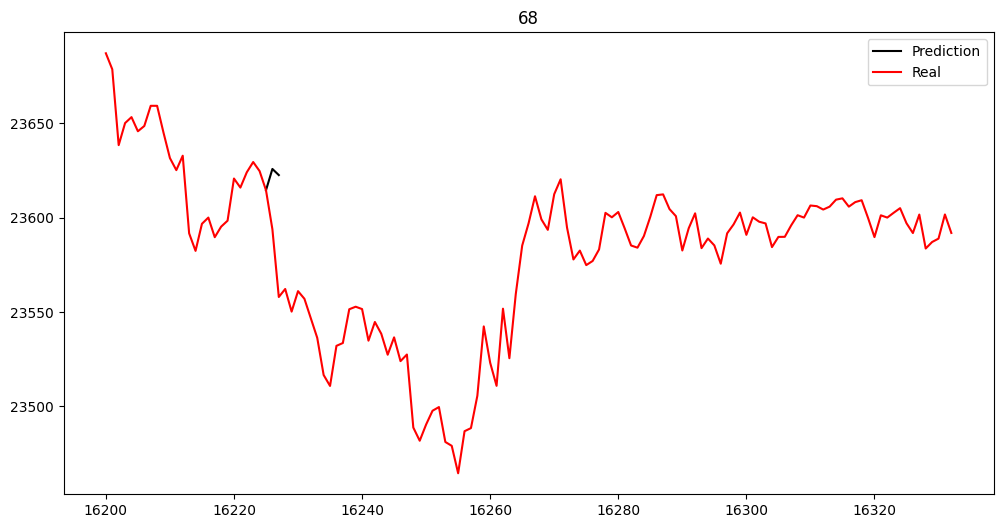

Actual: [23614.6, 23593.9, 23558.0]
prdiction [23614.6, 23625.87938079834, 23622.6309677124]
(16191, 3)
 49/506 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16190, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16189, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


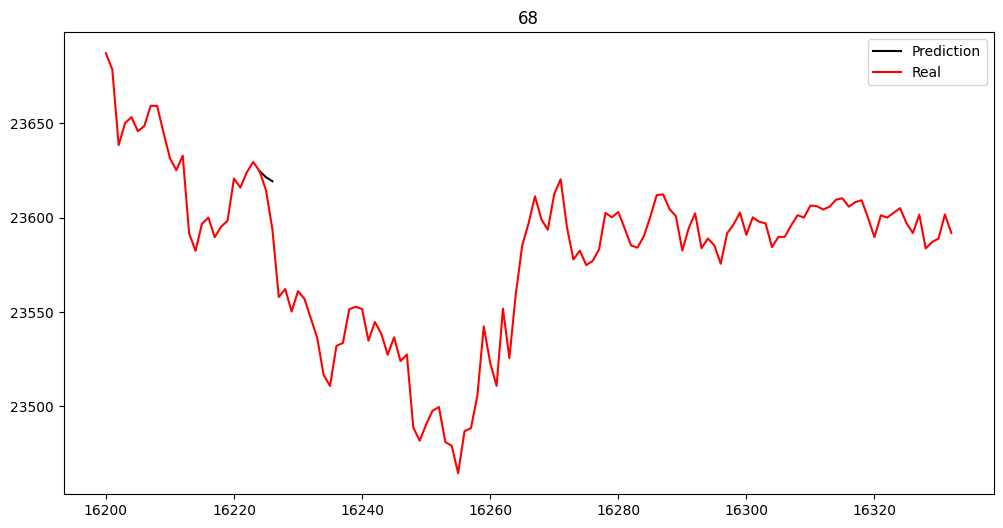

Actual: [23624.75, 23614.6, 23593.9]
prdiction [23624.75, 23621.501586914062, 23619.350578308105]
(16190, 3)
 25/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16189, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16188, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


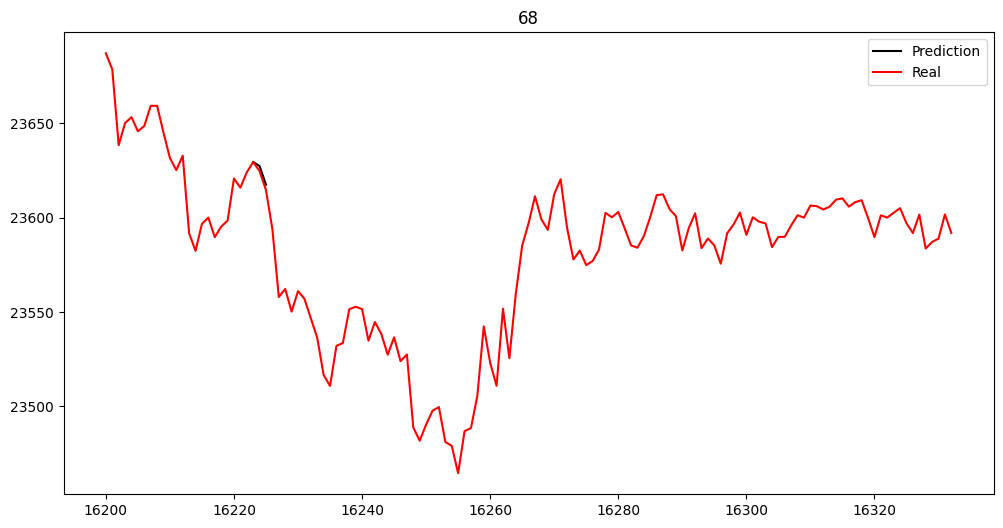

Actual: [23629.55, 23624.75, 23614.6]
prdiction [23629.55, 23627.398991394042, 23617.508366394042]
(16189, 3)
 42/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

<ipython-input-44-6fbcefab2148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['returns'] = c.close.pct_change()
<ipython-input-44-6fbcefab2148>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16188, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16187, 3)
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


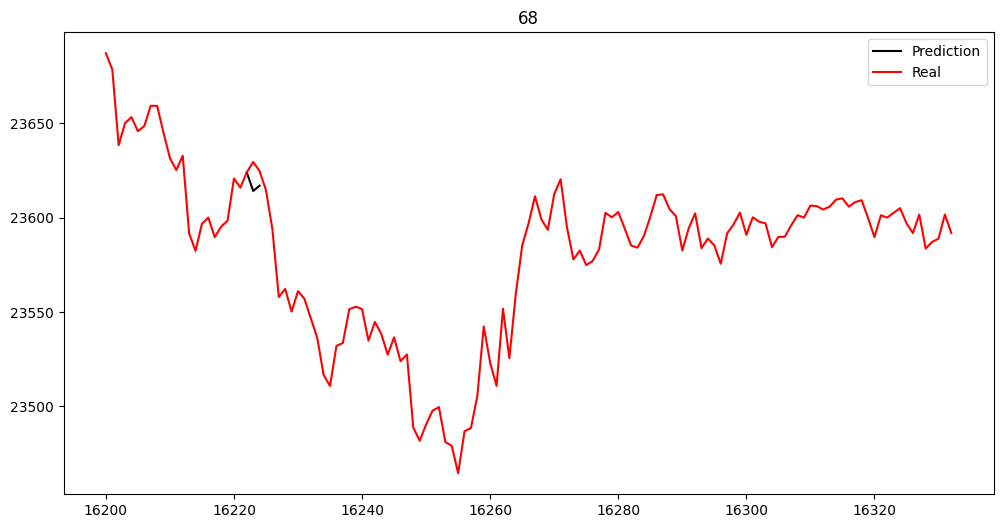

Actual: [23624.1, 23629.55, 23624.75]
prdiction [23624.1, 23614.209375, 23617.010171508788]


In [ ]:
bucket = []


while a <= b:

    xdata = data_ori.iloc[:-a, :]

    trima_temp = pd.DataFrame()
    xdata_pre = pd.DataFrame()
    slaes = 33

    fi_data = xdata[['close']]
    c = fi_data

    ############################## Indicators  ############################################################33


    c['returns'] = c.close.pct_change()

    returns = np.log(c['close'] / c['close'].shift(1))  # Log returns
    c['inute_volatility'] = returns.rolling(window=30).std() * np.sqrt(252*390)  # annualized vol

    trima_temp['TRIMA5'] = ta.mom(c['close'], length=8).iloc[slaes:]



    data = c.iloc[slaes:]
    data = data.reset_index(drop=True)

    target = pd.DataFrame()
    target = target.reset_index(drop=True)


    e = 4

    i = 0

    while i < e:

        i += 1

        target['1TRIMA5'] = trima_temp['TRIMA5'].shift(-i)

        target_fi = target.iloc[:-i, :]
        data_fi = data.iloc[:-i, :]


        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler(feature_range=(0,1))
        scx = MinMaxScaler(feature_range=(0,1))

        x_train = sc.fit_transform(data_fi)
        y_train = scx.fit_transform(target_fi)

        print(x_train.shape)

        data_750 = prepare_prediction_data(x_train, ts)


        #x_test = sc.fit_transform(data_750)

        y_pred_y = pd.DataFrame(model.predict(data_750))

        prediction_Row = y_pred_y.iloc[len(y_pred_y)-1].T

        prediction = pd.DataFrame(prediction_Row).drop_duplicates()

        real_pred = pd.DataFrame(scx.inverse_transform(prediction), columns=['close'])

        xdata_pre = pd.concat([xdata_pre, real_pred])

        last_index = xdata.index[-1]

        xdata_pre.index = range(last_index + 1, last_index + 1 + len(xdata_pre))

    combo =  pd.concat([fi_data['close'],xdata_pre], axis=0)
    pred = ta.trima(combo['close'], length=1).tail(e)

    if xdata['close'].tail(1).iloc[0] > pred.head(1).iloc[0]:
        put_diff = xdata['close'].tail(1).iloc[0] - pred.head(1).iloc[0]
        prediction = pred + put_diff

    else:
        call_diff = pred.head(1).iloc[0] - xdata['close'].tail(1).iloc[0]
        prediction = pred - call_diff

    prediction.index -= 1

    plt.figure(figsize=(12,6))
    plt.title('68')
    plt.plot(prediction, color = 'black', label = 'Prediction')
    plt.plot(data_ori['close'].iloc[16200:20000], color = 'red', label = 'Real')
    plt.legend()
    plt.show()


    indi = prediction

    start = indi.index[0]
    end = indi.index[-1]

    evalu = data_ori['close'].iloc[start:end+1]

    actual = evalu.values.tolist()

    prediction = prediction.values.tolist()

    print('Actual:', actual)
    print('prdiction',  prediction)


    import math
    import matplotlib.pyplot as plt
    import numpy as np

    def angle_evaluation(prediction, actual):
        """
        Evaluate angle between prediction and actual lines

        Args:
            prediction (list): Two values [y1, y2] defining prediction line
            actual (list): Two values [y1, y2] defining actual line

        Returns:
            tuple: (angle_score, should_continue)
            - angle_score: float value of angle score
            - should_continue: boolean indicating if length evaluation should be performed
        """
        def calculate_line_angle(points):
            try:
                y1, y2 = points
                x1, x2 = 0, 1  # Fixed x-coordinates for standardization

                dx = x2 - x1  # Will always be 1
                dy = y2 - y1

                angle = math.degrees(math.atan2(dx, -dy))  # Negative dy to match coordinate system

                if angle < 0:
                    angle += 180

                return angle
            except Exception as e:
                print(f"Error in calculate_line_angle: {e}")
                return 0

        try:
            pred_angle = calculate_line_angle(prediction)
            actual_angle = calculate_line_angle(actual)

            # Check if angles are on opposite sides of 90°
            if (pred_angle < 90 and actual_angle > 90) or (pred_angle > 90 and actual_angle < 90):
                return 0.0, False  # Return 0 score and False to skip length evaluation

            angle_diff = abs(pred_angle - actual_angle)

            if angle_diff == 0:
                return 100.0, True
            elif angle_diff == 90:
                return 0.0, True
            else:
                score = 100 - (angle_diff * (100 / 90))
                return max(0.0, min(score, 100.0)), True

        except Exception as e:
            print(f"Error in angle_evaluation: {e}")
            return 0.0, False

    def length_evaluation(prediction, actual):
        """
        Evaluate length between prediction and actual lines

        Args:
            prediction (list): Two values [y1, y2] defining prediction line
            actual (list): Two values [y1, y2] defining actual line

        Returns:
            float: Length evaluation score
        """
        def euclidean_distance(points):
            try:
                y1, y2 = points
                x1, x2 = 0, 1
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                return distance
            except Exception as e:
                print(f"Error in euclidean_distance: {e}")
                return 0

        try:
            pred_distance = euclidean_distance(prediction)
            actual_distance = euclidean_distance(actual)

            if pred_distance == actual_distance:
                return 100.0

            shorter_line = min(pred_distance, actual_distance)
            longer_line = max(pred_distance, actual_distance)

            score = (shorter_line / longer_line) * 100
            return max(0.0, min(score, 100.0))
        except Exception as e:
            print(f"Error in length_evaluation: {e}")
            return 0.0

    def mcem_final_evaluation(prediction, actual):
        """
        Calculate final MCEM score

        Args:
            prediction (list): Two values [y1, y2] defining prediction line
            actual (list): Two values [y1, y2] defining actual line

        Returns:
            tuple: (final_score, angle_score, length_score)
        """
        try:
            angle_score, should_continue = angle_evaluation(prediction, actual)

            if not should_continue:  # If angles are on opposite sides of 90°
                return 0.0, angle_score, 0.0

            length_score = length_evaluation(prediction, actual)
            final_score = (angle_score + length_score) / 2

            return round(final_score, 2), angle_score, length_score
        except Exception as e:
            print(f"Error in mcem_final_evaluation: {e}")
            return 0.0, 0.0, 0.0


    # Create pairs of consecutive points for both actual and prediction
    actual_pairs = [[actual[i], actual[i+1]] for i in range(len(actual)-1)]
    prediction_pairs = [[prediction[i], prediction[i+1]] for i in range(len(prediction)-1)]

    # Calculate scores for all pairs
    all_scores = []
    all_angle_scores = []
    all_length_scores = []

    for i in range(len(prediction_pairs)):
        score, angle_score, length_score = mcem_final_evaluation(prediction_pairs[i], actual_pairs[i])
        all_scores.append(score)
        all_angle_scores.append(angle_score)
        all_length_scores.append(length_score)

    # Calculate mean scores
    mean_score = np.mean(all_scores)
    mean_angle_score = np.mean(all_angle_scores)
    mean_length_score = np.mean(all_length_scores)

    # Create a single plot showing all line segments
    #plt.figure(figsize=(6, 4))
    #plt.title(f"Mean Score: {mean_score:.2f}, Mean Angle Score: {mean_angle_score:.2f}, Mean Length Score: {mean_length_score:.2f}")

    # Create x-coordinates for the full line
    x_coords = list(range(len(actual)))

    # Plot the full lines
    #plt.plot(x_coords, actual, 'ro-', label='Actual')
    #plt.plot(x_coords, prediction, 'k.-', label='Prediction')

    # Add individual segment scores as text
    for i in range(len(prediction_pairs)):
        # Position the text at the midpoint of each segment
        x_mid = i + 0.5
        y_mid = (prediction[i] + prediction[i+1]) / 2



    #plt.xlabel('Index')
    #plt.ylabel('Value')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()

    score = round(float(mean_score), 2)
    bucket.append(score)


    a += 1

In [ ]:
round(float((sum(bucket)/len(bucket))), 2)

38.63

In [ ]:
32.65

#model.save('LSTM_5_k33_TV_Upgrade_35.3.keras')

#import shutil
#shutil.move("/content/LSTM_5_k33_TV_Upgrade_35.3.keras", "/content/drive/MyDrive/LSTM_5_k33_TV_Upgrade_35.3.keras")

32.65